# **Convert detailed management info to machine-readable format**

Detailed management information (dates, types, amount N) was converted to a machine-readable format following these steps: 
1. Management events were identified, and a variable name was created for each event (`MGMT_SPECIFIC`). Between Jan 2005 and Aug 2024, 479 management events were taking place, with 30 unique events identified (Table 1).   
2. Similar events were grouped together (e.g., all grazing, all mowing, …) and parcel info was added to the variable names (Table 2).

# Imports

In [1]:
import datetime
from collections import Counter
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from diive.core.io.files import save_parquet, load_parquet
from diive.pkgs.createvar.timesince import TimeSince
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.plotting.timeseries import TimeSeries

# Read data

## Read wind direction data from merged flux data
- Here only needed for wind direction `WD`

In [2]:
FILEPATH = r"../50_FluxProcessingChain/53.1_FluxProcessingChain_after-L3.3_NEE_LE_H.parquet"
fluxdf = load_parquet(filepath=FILEPATH)
winddir = fluxdf['WD'].copy()
winddir

Loaded .parquet file ../50_FluxProcessingChain/53.1_FluxProcessingChain_after-L3.3_NEE_LE_H.parquet (0.559 seconds). Detected time resolution of <30 * Minutes> / 30min 


TIMESTAMP_MIDDLE
2005-01-01 00:15:00        NaN
2005-01-01 00:45:00        NaN
2005-01-01 01:15:00        NaN
2005-01-01 01:45:00        NaN
2005-01-01 02:15:00        NaN
                        ...   
2023-12-31 21:45:00    116.724
2023-12-31 22:15:00    116.197
2023-12-31 22:45:00    142.519
2023-12-31 23:15:00    140.207
2023-12-31 23:45:00    135.988
Freq: 30min, Name: WD, Length: 333072, dtype: float64

## Read management data

In [3]:
file_mgmt = r"../0_data/MANAGEMENT/CH-CHA-Management_2005-2024_20241107.xlsx"
sheet = "CHA_Management"
mgmt_detailed = pd.read_excel(file_mgmt, sheet_name=sheet)
mgmt_detailed = mgmt_detailed.loc[:, ['Parcel', 'Management_Category', 'Management_Subcategory', 'Management_specific', 'Start', 'End', 'Total Fertilizer N (kg/ha)']]
mgmt_detailed 

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha)
0,A,Fertilization,Organic fertilizer,Manure,2001-01-15,NaT,206.700313
1,A,Plant protection and growth maintenance,Herbe removal,Rumex removal,2001-03-30,NaT,NaN
2,A,Plant protection and growth maintenance,Harrowing,Harrowing (1 cm),2001-04-02,NaT,NaN
3,A,Use,Grazing,Cattle,2001-05-07,2001-05-15,NaN
4,A,Plant protection and growth maintenance,Rolling,NaN,2001-06-07,NaT,NaN
...,...,...,...,...,...,...,...
573,B,Fertilization,Organic fertilizer,Slurry,2024-06-27,2024-06-27,NaN
574,B,Use,Mowing,NaN,2024-07-17,2024-07-17,NaN
575,B,Fertilization,Organic fertilizer,Slurry,2024-08-07,2024-08-07,NaN
576,B,Use,Mowing,NaN,2024-08-22,2024-08-22,NaN


# **MANAGEMENT DATA PREPARATION**

## Handle missing management info

In [4]:
# Fill end dates, if missing then end is the same as start
mgmt_detailed['End'] = mgmt_detailed['End'].fillna(mgmt_detailed['Start'])

mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].fillna('-9999')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].fillna('-9999')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].fillna('-9999')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].fillna('-9999')
mgmt_detailed['Total Fertilizer N (kg/ha)'] = mgmt_detailed['Total Fertilizer N (kg/ha)'].fillna(0)

## Make full timestamp for start and end dates
- The full timestamp for start and end dates takes into account that the flux records are stored with a timestamp that shows the END of the averaging interval
- This means that a record with timestamp `2021-06-05 00:00` contains data between `2021-06-04 23:30` (exclusive) and `2021-06-05 00:00` (inclusive)
- To correctly assign a management to a specific day, one second needs to be added to the start date (because the time 00:00 still has data from the *previous* day)
- For the end data to cover the full day, 24 hours need to be added and in addition one second, to include the 00:00 time of the next day

In [5]:
mgmt_detailed['Start'] = pd.to_datetime(mgmt_detailed['Start']).add(datetime.timedelta(seconds=1))
mgmt_detailed['End'] = pd.to_datetime(mgmt_detailed['End']).add(datetime.timedelta(hours=24, seconds=1))
mgmt_detailed

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha)
0,A,Fertilization,Organic fertilizer,Manure,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313
1,A,Plant protection and growth maintenance,Herbe removal,Rumex removal,2001-03-30 00:00:01,2001-03-31 00:00:01,0.000000
2,A,Plant protection and growth maintenance,Harrowing,Harrowing (1 cm),2001-04-02 00:00:01,2001-04-03 00:00:01,0.000000
3,A,Use,Grazing,Cattle,2001-05-07 00:00:01,2001-05-16 00:00:01,0.000000
4,A,Plant protection and growth maintenance,Rolling,-9999,2001-06-07 00:00:01,2001-06-08 00:00:01,0.000000
...,...,...,...,...,...,...,...
573,B,Fertilization,Organic fertilizer,Slurry,2024-06-27 00:00:01,2024-06-28 00:00:01,0.000000
574,B,Use,Mowing,-9999,2024-07-17 00:00:01,2024-07-18 00:00:01,0.000000
575,B,Fertilization,Organic fertilizer,Slurry,2024-08-07 00:00:01,2024-08-08 00:00:01,0.000000
576,B,Use,Mowing,-9999,2024-08-22 00:00:01,2024-08-23 00:00:01,0.000000


# **MANAGEMENT EVENTS**

## Create MGMT_specific names

In [6]:
mgmt_detailed['PREFIX'] = 'MGMT'

mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].str.replace('A', 'PARCEL-A')
mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].str.replace('B', 'PARCEL-B')

mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Fertilization', 'FERT')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Plant protection and growth maintenance', 'PPGM')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Use', 'USE')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Sowing', 'SOWING')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Soil cultivation', 'SOILCULTIVATION')

mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Organic fertilizer', 'ORG')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Mineral fertilizer', 'MIN')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Herbe removal', 'HERBREMOVAL')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Harrowing', 'HARROWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Grazing', 'GRAZING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Rolling', 'ROLLING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Oversowing', 'OVERSOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Mowing', 'MOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Herbicide', 'HERBICIDE')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Ploughing', 'PLOUGHING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Resowing', 'RESOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Pesticide', 'PESTICIDE')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Tillage', 'TILLAGE')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Manure', 'MAN')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Slurry', 'SLU')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Calcium ammonium nitrate', 'CAN')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Molluscicide (applied on the whole field)', 'MOLLUSCICIDE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harmony tabs (applied on single plants against Rumex obtusifolius)', 'HARMONYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Ally Tabs (applied on single plants against Rumex spp.)', 'ALLYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Ally Tabs (applied against Rumex spp. and Senecio spp.)', 'ALLYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Hay', 'HAY')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Sheep', 'SHEEP')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Cattle', 'CATTLE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Aftergrass', 'AFTERGRASS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Asulox (applied on the whole field against Rumex obtusifolius)', 'ASULOX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Rumex removal', 'RUMEX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harrowing (1 cm)', '1CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harrowing (7 cm)', '7CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Roundup PowerMax', 'ROUNDUP')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 Extra', 'OH440EXTRA')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('?', '-9999')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 RenoTurbo', 'OH440RENOTURBO')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 Reno', 'OH440RENO')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 240 Reno', 'OH240RENO')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Asulam (applied on the whole field against Rumex obtusifolius)', 'ASULAM')
# df['Management_specific'] = df['Management_specific'].str.replace('HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MARULA: Trifolium pratense. Total 20 kg/ha. Mixture: 27% HEBE  36% FIONA 36% MERULA (15 kg + 20 kg + 20 kg)', '-9999')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Grass silage', 'GRASSSILAGE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('UFA 420', 'UFA-420')

s = "HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MERULA: Trifolium pratense. Total 20 kg/ha. Mixture: 1/4 HEBE  1/2 FIONA 1/4 MERULA"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-MERULA')

s = "HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MARULA: Trifolium pratense. Total 20 kg/ha. Mixture: 27% HEBE  36% FIONA 36% MERULA (15 kg + 20 kg + 20 kg)"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-MERULA')

s = "Type OH (HEBE FIONA TEDI). Trifolium pratense 4n Sorte TEDI - Trifolium repens Sorte HEBE - Trifolium repens Sorte FIONA. Total 200 g/a of each 1/3"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-TEDI')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Hobelsaat (tillage until 3-4 cm)', '3-4CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('XXX', 'XXX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('XXX', 'XXX')

def create_varname(row): 
    return "_".join([
        row['PREFIX'],        
        row['Management_Category'], 
        row['Management_Subcategory'],
        str(row['Management_specific']),
        # row['Parcel']
    ])

mgmt_detailed['MGMT_SPECIFIC'] = mgmt_detailed.apply(create_varname, axis=1)
mgmt_detailed['MGMT_SPECIFIC'] = mgmt_detailed['MGMT_SPECIFIC'].str.replace('_-9999', '')
mgmt_types = mgmt_detailed['MGMT_SPECIFIC'].unique()
print("Unique specific managements:")
[print(f"{ix}: {v}") for ix, v in enumerate(mgmt_types)];

Unique specific managements:
0: MGMT_FERT_ORG_MAN
1: MGMT_PPGM_HERBREMOVAL_RUMEX
2: MGMT_PPGM_HARROWING_1CM
3: MGMT_USE_GRAZING_CATTLE
4: MGMT_PPGM_ROLLING
5: MGMT_PPGM_HARROWING_7CM
6: MGMT_SOWING_OVERSOWING_OH440RENO
7: MGMT_USE_MOWING_GRASSSILAGE
8: MGMT_FERT_MIN_CAN
9: MGMT_FERT_ORG_SLU
10: MGMT_USE_GRAZING_SHEEP
11: MGMT_SOWING_OVERSOWING_OH440EXTRA
12: MGMT_USE_MOWING_AFTERGRASS
13: MGMT_PPGM_HERBICIDE_ASULOX
14: MGMT_SOILCULTIVATION_ROLLING
15: MGMT_USE_MOWING_HAY
16: MGMT_SOWING_OVERSOWING_OH440RENOTURBO
17: MGMT_SOWING_OVERSOWING_OH240RENO
18: MGMT_PPGM_HERBICIDE_ALLYTABS
19: MGMT_SOILCULTIVATION_PLOUGHING
20: MGMT_SOILCULTIVATION_HARROWING_7CM
21: MGMT_SOWING_RESOWING_OH440EXTRA
22: MGMT_PPGM_PESTICIDE_MOLLUSCICIDE
23: MGMT_PPGM_HERBICIDE_HARMONYTABS
24: MGMT_PPGM_HERBICIDE_ASULAM
25: MGMT_SOWING_OVERSOWING_HEBE-FIONA-TEDI
26: MGMT_SOILCULTIVATION_HARROWING_1CM
27: MGMT_USE_MOWING
28: MGMT_SOWING_OVERSOWING_HEBE-FIONA-MERULA
29: MGMT_PPGM_HERBICIDE_ROUNDUP
30: MGMT_SOILCULTIV

In [7]:
mgmt_detailed

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC
0,PARCEL-A,FERT,ORG,MAN,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313,MGMT,MGMT_FERT_ORG_MAN
1,PARCEL-A,PPGM,HERBREMOVAL,RUMEX,2001-03-30 00:00:01,2001-03-31 00:00:01,0.000000,MGMT,MGMT_PPGM_HERBREMOVAL_RUMEX
2,PARCEL-A,PPGM,HARROWING,1CM,2001-04-02 00:00:01,2001-04-03 00:00:01,0.000000,MGMT,MGMT_PPGM_HARROWING_1CM
3,PARCEL-A,USE,GRAZING,CATTLE,2001-05-07 00:00:01,2001-05-16 00:00:01,0.000000,MGMT,MGMT_USE_GRAZING_CATTLE
4,PARCEL-A,PPGM,ROLLING,-9999,2001-06-07 00:00:01,2001-06-08 00:00:01,0.000000,MGMT,MGMT_PPGM_ROLLING
...,...,...,...,...,...,...,...,...,...
573,PARCEL-B,FERT,ORG,SLU,2024-06-27 00:00:01,2024-06-28 00:00:01,0.000000,MGMT,MGMT_FERT_ORG_SLU
574,PARCEL-B,USE,MOWING,-9999,2024-07-17 00:00:01,2024-07-18 00:00:01,0.000000,MGMT,MGMT_USE_MOWING
575,PARCEL-B,FERT,ORG,SLU,2024-08-07 00:00:01,2024-08-08 00:00:01,0.000000,MGMT,MGMT_FERT_ORG_SLU
576,PARCEL-B,USE,MOWING,-9999,2024-08-22 00:00:01,2024-08-23 00:00:01,0.000000,MGMT,MGMT_USE_MOWING


## Counts of MGMT_SPECIFIC names

In [8]:
counts = Counter(mgmt_detailed['MGMT_SPECIFIC'])
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
rename_dict = {'index': 'MGMT_SPECIFIC', 0: 'COUNTS'}
counts_df = counts_df.rename(columns=rename_dict, inplace=False)
counts_df = counts_df.sort_values(by='COUNTS', ascending=False)
counts_df.to_csv("16.1_mgmt_specific_counts.csv", index=False)
counts_df

,MGMT_SPECIFIC,COUNTS
9,MGMT_FERT_ORG_SLU,190
7,MGMT_USE_MOWING_GRASSSILAGE,134
10,MGMT_USE_GRAZING_SHEEP,60
27,MGMT_USE_MOWING,41
12,MGMT_USE_MOWING_AFTERGRASS,36
15,MGMT_USE_MOWING_HAY,17
6,MGMT_SOWING_OVERSOWING_OH440RENO,12
3,MGMT_USE_GRAZING_CATTLE,8
2,MGMT_PPGM_HARROWING_1CM,8
0,MGMT_FERT_ORG_MAN,7


## Create MGMT variable names (simplified, grouped)

In [9]:
mgmt_detailed['MGMT_GENERAL'] = ''
mgmt_detailed['MGMT_PARCEL'] = ''

def rename(startswith, replacewith):
    
    locs = mgmt_detailed['MGMT_SPECIFIC'].str.startswith(startswith)

    mgmt_detailed.loc[locs, 'MGMT_GENERAL'] = replacewith
    mgmt_detailed.loc[locs, 'MGMT_PARCEL'] = replacewith + "_" + mgmt_detailed.loc[locs, 'Parcel']
    display(mgmt_detailed[locs].head(1))   
    print(f"Records: {len(mgmt_detailed[locs])}")

rename(startswith="MGMT_USE_MOWING", replacewith="MGMT_MOWING")

rename(startswith="MGMT_USE_GRAZING", replacewith="MGMT_GRAZING")

rename(startswith="MGMT_SOWING", replacewith="MGMT_SOWING")

rename(startswith="MGMT_SOILCULTIVATION", replacewith="MGMT_SOILCULTIVATION")
rename(startswith="MGMT_PPGM_HARROWING", replacewith="MGMT_SOILCULTIVATION")
rename(startswith="MGMT_PPGM_ROLLING", replacewith="MGMT_SOILCULTIVATION")

rename(startswith="MGMT_PPGM_PESTICIDE", replacewith="MGMT_PESTICIDE_HERBICIDE")
rename(startswith="MGMT_PPGM_HERBREMOVAL", replacewith="MGMT_PESTICIDE_HERBICIDE")
rename(startswith="MGMT_PPGM_HERBICIDE", replacewith="MGMT_PESTICIDE_HERBICIDE")

rename(startswith="MGMT_FERT_ORG", replacewith="MGMT_FERT_ORG")
rename(startswith="MGMT_FERT_MIN", replacewith="MGMT_FERT_MIN")

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
7,PARCEL-A,USE,MOWING,GRASSSILAGE,2001-07-25 00:00:01,2001-07-26 00:00:01,0.0,MGMT,MGMT_USE_MOWING_GRASSSILAGE,MGMT_MOWING,MGMT_MOWING_PARCEL-A


Records: 228


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
3,PARCEL-A,USE,GRAZING,CATTLE,2001-05-07 00:00:01,2001-05-16 00:00:01,0.0,MGMT,MGMT_USE_GRAZING_CATTLE,MGMT_GRAZING,MGMT_GRAZING_PARCEL-A


Records: 68


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
6,PARCEL-A,SOWING,OVERSOWING,OH440RENO,2001-06-07 00:00:01,2001-06-08 00:00:01,0.0,MGMT,MGMT_SOWING_OVERSOWING_OH440RENO,MGMT_SOWING,MGMT_SOWING_PARCEL-A


Records: 27


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
139,PARCEL-B,SOILCULTIVATION,ROLLING,-9999,2006-03-27 00:00:01,2006-03-28 00:00:01,0.0,MGMT,MGMT_SOILCULTIVATION_ROLLING,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-B


Records: 16


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
2,PARCEL-A,PPGM,HARROWING,1CM,2001-04-02 00:00:01,2001-04-03 00:00:01,0.0,MGMT,MGMT_PPGM_HARROWING_1CM,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A


Records: 9


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
4,PARCEL-A,PPGM,ROLLING,-9999,2001-06-07 00:00:01,2001-06-08 00:00:01,0.0,MGMT,MGMT_PPGM_ROLLING,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A


Records: 3


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
306,PARCEL-A,PPGM,PESTICIDE,MOLLUSCICIDE,2012-06-19 00:00:01,2012-06-20 00:00:01,0.0,MGMT,MGMT_PPGM_PESTICIDE_MOLLUSCICIDE,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-A


Records: 2


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
1,PARCEL-A,PPGM,HERBREMOVAL,RUMEX,2001-03-30 00:00:01,2001-03-31 00:00:01,0.0,MGMT,MGMT_PPGM_HERBREMOVAL_RUMEX,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-A


Records: 3


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
70,PARCEL-B,PPGM,HERBICIDE,ASULOX,2003-09-22 00:00:01,2003-09-23 00:00:01,0.0,MGMT,MGMT_PPGM_HERBICIDE_ASULOX,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-B


Records: 18


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
0,PARCEL-A,FERT,ORG,MAN,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313,MGMT,MGMT_FERT_ORG_MAN,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-A


Records: 197


,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
8,PARCEL-A,FERT,MIN,CAN,2001-08-06 00:00:01,2001-08-07 00:00:01,17.55,MGMT,MGMT_FERT_MIN_CAN,MGMT_FERT_MIN,MGMT_FERT_MIN_PARCEL-A


Records: 7


In [10]:
mgmt_detailed

,Parcel,Management_Category,Management_Subcategory,Management_specific,Start,End,Total Fertilizer N (kg/ha),PREFIX,MGMT_SPECIFIC,MGMT_GENERAL,MGMT_PARCEL
0,PARCEL-A,FERT,ORG,MAN,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313,MGMT,MGMT_FERT_ORG_MAN,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-A
1,PARCEL-A,PPGM,HERBREMOVAL,RUMEX,2001-03-30 00:00:01,2001-03-31 00:00:01,0.000000,MGMT,MGMT_PPGM_HERBREMOVAL_RUMEX,MGMT_PESTICIDE_HERBICIDE,MGMT_PESTICIDE_HERBICIDE_PARCEL-A
2,PARCEL-A,PPGM,HARROWING,1CM,2001-04-02 00:00:01,2001-04-03 00:00:01,0.000000,MGMT,MGMT_PPGM_HARROWING_1CM,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A
3,PARCEL-A,USE,GRAZING,CATTLE,2001-05-07 00:00:01,2001-05-16 00:00:01,0.000000,MGMT,MGMT_USE_GRAZING_CATTLE,MGMT_GRAZING,MGMT_GRAZING_PARCEL-A
4,PARCEL-A,PPGM,ROLLING,-9999,2001-06-07 00:00:01,2001-06-08 00:00:01,0.000000,MGMT,MGMT_PPGM_ROLLING,MGMT_SOILCULTIVATION,MGMT_SOILCULTIVATION_PARCEL-A
...,...,...,...,...,...,...,...,...,...,...,...
573,PARCEL-B,FERT,ORG,SLU,2024-06-27 00:00:01,2024-06-28 00:00:01,0.000000,MGMT,MGMT_FERT_ORG_SLU,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-B
574,PARCEL-B,USE,MOWING,-9999,2024-07-17 00:00:01,2024-07-18 00:00:01,0.000000,MGMT,MGMT_USE_MOWING,MGMT_MOWING,MGMT_MOWING_PARCEL-B
575,PARCEL-B,FERT,ORG,SLU,2024-08-07 00:00:01,2024-08-08 00:00:01,0.000000,MGMT,MGMT_FERT_ORG_SLU,MGMT_FERT_ORG,MGMT_FERT_ORG_PARCEL-B
576,PARCEL-B,USE,MOWING,-9999,2024-08-22 00:00:01,2024-08-23 00:00:01,0.000000,MGMT,MGMT_USE_MOWING,MGMT_MOWING,MGMT_MOWING_PARCEL-B


In [11]:
print("Check for missing management info:")
mgmt_detailed.isnull().sum()

Check for missing management info:


Parcel                        0
Management_Category           0
Management_Subcategory        0
Management_specific           0
Start                         0
End                           0
Total Fertilizer N (kg/ha)    0
PREFIX                        0
MGMT_SPECIFIC                 0
MGMT_GENERAL                  0
MGMT_PARCEL                   0
dtype: int64

In [12]:
counts = Counter(mgmt_detailed['MGMT_PARCEL'])
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
rename_dict = {'index': 'MGMT_PARCEL', 0: 'COUNTS'}
counts_df = counts_df.rename(columns=rename_dict, inplace=False)
counts_df = counts_df.sort_values(by='COUNTS', ascending=False)
counts_df.to_csv("16.2_mgmt_parcel_counts.csv", index=False)
counts_df

,MGMT_PARCEL,COUNTS
9,MGMT_MOWING_PARCEL-B,118
0,MGMT_FERT_ORG_PARCEL-A,112
5,MGMT_MOWING_PARCEL-A,110
7,MGMT_FERT_ORG_PARCEL-B,85
11,MGMT_GRAZING_PARCEL-B,35
3,MGMT_GRAZING_PARCEL-A,33
12,MGMT_SOWING_PARCEL-B,21
8,MGMT_SOILCULTIVATION_PARCEL-B,17
10,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,12
1,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,11


## Create full timestamp, starting with year of first management event in 2001

In [13]:
timestamp_full = pd.date_range("2001-01-01 00:15:00", fluxdf.index[-1], freq='30min')
timestamp_full

DatetimeIndex(['2001-01-01 00:15:00', '2001-01-01 00:45:00', '2001-01-01 01:15:00', '2001-01-01 01:45:00', '2001-01-01 02:15:00', '2001-01-01 02:45:00', '2001-01-01 03:15:00', '2001-01-01 03:45:00', '2001-01-01 04:15:00', '2001-01-01 04:45:00',
               ...
               '2023-12-31 19:15:00', '2023-12-31 19:45:00', '2023-12-31 20:15:00', '2023-12-31 20:45:00', '2023-12-31 21:15:00', '2023-12-31 21:45:00', '2023-12-31 22:15:00', '2023-12-31 22:45:00', '2023-12-31 23:15:00', '2023-12-31 23:45:00'], dtype='datetime64[ns]', length=403200, freq='30min')

## Create empty management dataframe with full timestamp index

In [14]:
cols = counts_df['MGMT_PARCEL'].tolist()
mgmt = pd.DataFrame(index=timestamp_full, columns=cols)
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B
2001-01-01 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 02:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Insert management info into management dataframe with full timestamp

In [15]:
for ix, event in mgmt_detailed.iterrows():
    varname = event['MGMT_PARCEL']
    start = event['Start']
    end = event['End']
    print(varname, start, end)
    locs = (mgmt.index >= start) & (mgmt.index <= end)    
    mgmt.loc[locs, varname] = 1    

mgmt = mgmt.fillna(0)

MGMT_FERT_ORG_PARCEL-A 2001-01-15 00:00:01 2001-01-16 00:00:01
MGMT_PESTICIDE_HERBICIDE_PARCEL-A 2001-03-30 00:00:01 2001-03-31 00:00:01
MGMT_SOILCULTIVATION_PARCEL-A 2001-04-02 00:00:01 2001-04-03 00:00:01
MGMT_GRAZING_PARCEL-A 2001-05-07 00:00:01 2001-05-16 00:00:01
MGMT_SOILCULTIVATION_PARCEL-A 2001-06-07 00:00:01 2001-06-08 00:00:01
MGMT_SOILCULTIVATION_PARCEL-A 2001-06-07 00:00:01 2001-06-08 00:00:01
MGMT_SOWING_PARCEL-A 2001-06-07 00:00:01 2001-06-08 00:00:01
MGMT_MOWING_PARCEL-A 2001-07-25 00:00:01 2001-07-26 00:00:01
MGMT_FERT_MIN_PARCEL-A 2001-08-06 00:00:01 2001-08-07 00:00:01
MGMT_MOWING_PARCEL-A 2001-08-21 00:00:01 2001-08-24 00:00:01
MGMT_PESTICIDE_HERBICIDE_PARCEL-A 2001-09-12 00:00:01 2001-09-13 00:00:01
MGMT_MOWING_PARCEL-A 2001-10-15 00:00:01 2001-10-17 00:00:01
MGMT_FERT_ORG_PARCEL-B 2001-01-16 00:00:01 2001-01-17 00:00:01
MGMT_FERT_ORG_PARCEL-B 2001-03-30 00:00:01 2001-03-31 00:00:01
MGMT_SOILCULTIVATION_PARCEL-B 2001-04-20 00:00:01 2001-04-21 00:00:01
MGMT_MOWING_PA

C:\Users\holukas\AppData\Local\Temp\ipykernel_12260\3643960705.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mgmt = mgmt.fillna(0)


In [16]:
mgmt.describe()

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B
count,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000,403200.000000
mean,0.020588,0.013227,0.019120,0.010119,0.046610,0.050002,0.002517,0.001560,0.001310,0.001190,0.000952,0.000714,0.000595,0.000238
std,0.142000,0.114244,0.136945,0.100083,0.210802,0.217950,0.050110,0.039466,0.036164,0.034483,0.030846,0.026717,0.024390,0.015429
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
mgmt.columns

Index(['MGMT_MOWING_PARCEL-B', 'MGMT_FERT_ORG_PARCEL-A', 'MGMT_MOWING_PARCEL-A', 'MGMT_FERT_ORG_PARCEL-B', 'MGMT_GRAZING_PARCEL-B', 'MGMT_GRAZING_PARCEL-A', 'MGMT_SOWING_PARCEL-B', 'MGMT_SOILCULTIVATION_PARCEL-B', 'MGMT_PESTICIDE_HERBICIDE_PARCEL-B', 'MGMT_PESTICIDE_HERBICIDE_PARCEL-A', 'MGMT_SOILCULTIVATION_PARCEL-A', 'MGMT_SOWING_PARCEL-A', 'MGMT_FERT_MIN_PARCEL-A', 'MGMT_FERT_MIN_PARCEL-B'], dtype='object')

### Plots

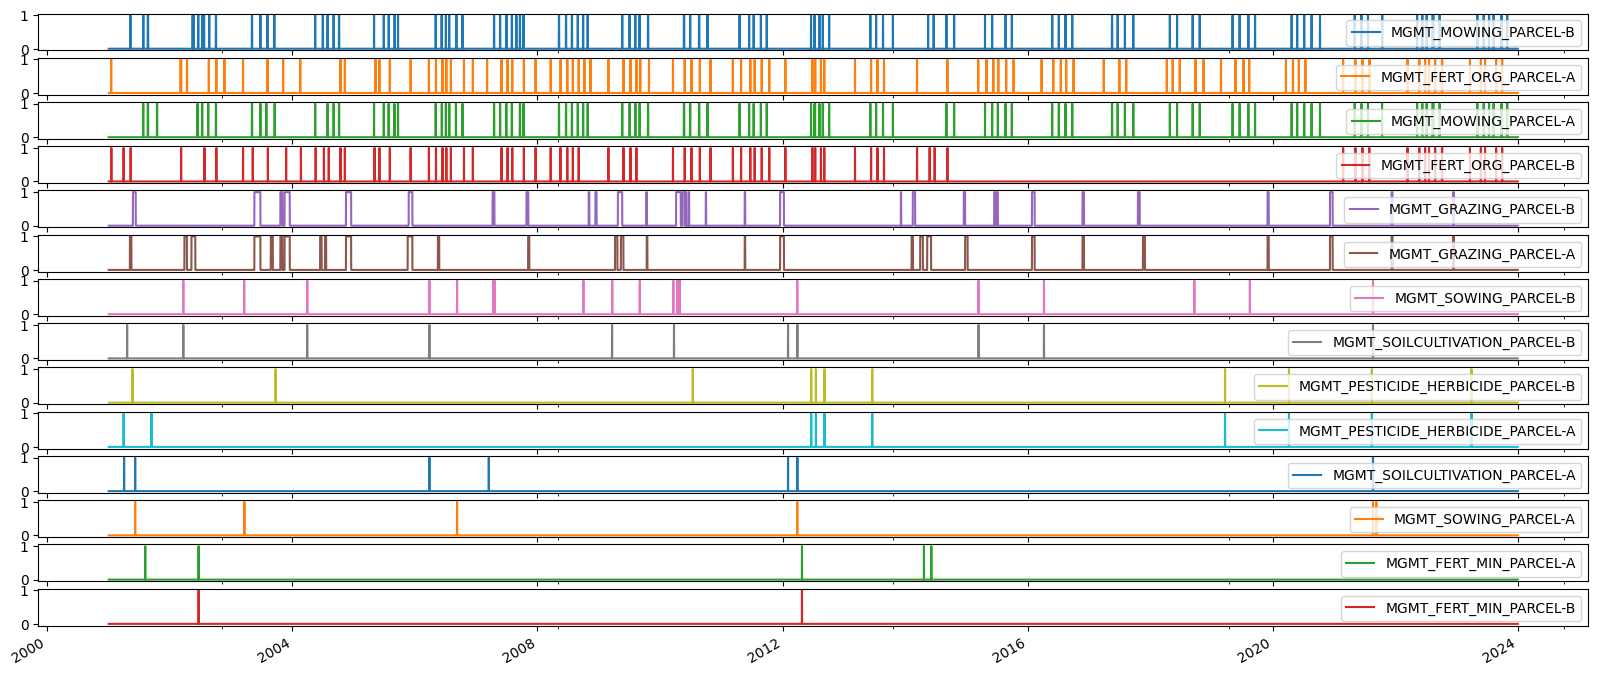

In [18]:
mgmt.plot(x_compat=True, subplots=True, figsize=(20, 9));

## Calculate `TIMESINCE` management event

In [19]:
timesincedf = pd.DataFrame()

for v in mgmt.columns:
    series = mgmt[v].squeeze()    
    ts = TimeSince(series, lower_lim=1, include_lim=True)
    ts.calc()
    # ts_full_results = ts.get_full_results()
    timesince = ts.get_timesince()
    timesincedf[timesince.name] = timesince

In [20]:
timesincedf

,TIMESINCE_MGMT_MOWING_PARCEL-B,TIMESINCE_MGMT_FERT_ORG_PARCEL-A,TIMESINCE_MGMT_MOWING_PARCEL-A,TIMESINCE_MGMT_FERT_ORG_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B
2001-01-01 00:15:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2001-01-01 00:45:00,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2001-01-01 01:15:00,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2001-01-01 01:45:00,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2001-01-01 02:15:00,5,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,2972,4460,2972,4460,18284,18284,41420,41420,13244,13244,41420,40460,167804,204812
2023-12-31 22:15:00,2973,4461,2973,4461,18285,18285,41421,41421,13245,13245,41421,40461,167805,204813
2023-12-31 22:45:00,2974,4462,2974,4462,18286,18286,41422,41422,13246,13246,41422,40462,167806,204814
2023-12-31 23:15:00,2975,4463,2975,4463,18287,18287,41423,41423,13247,13247,41423,40463,167807,204815


### Plots

C:\Users\holukas\AppData\Local\miniconda3\envs\cha_fp2024\lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\holukas\AppData\Local\miniconda3\envs\cha_fp2024\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


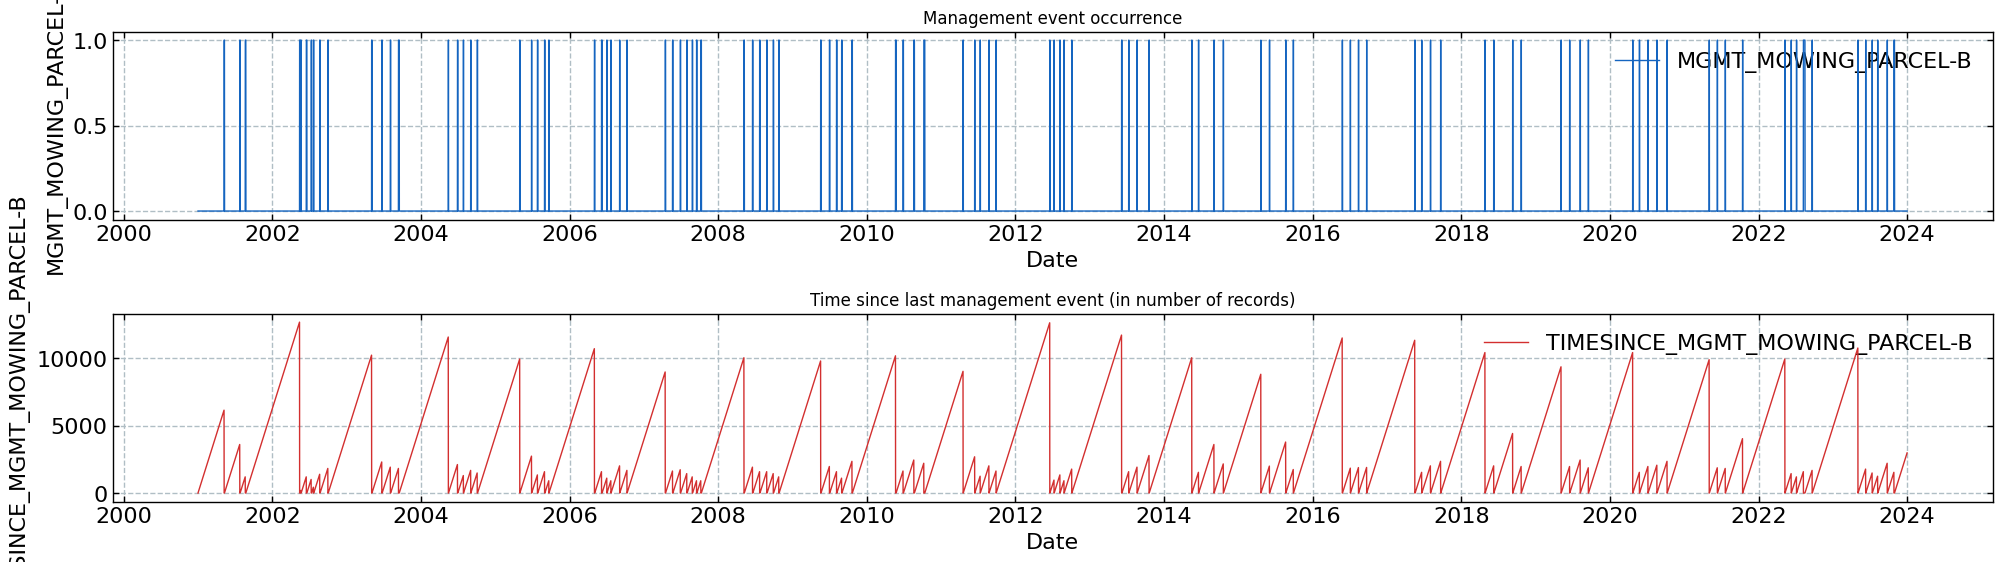

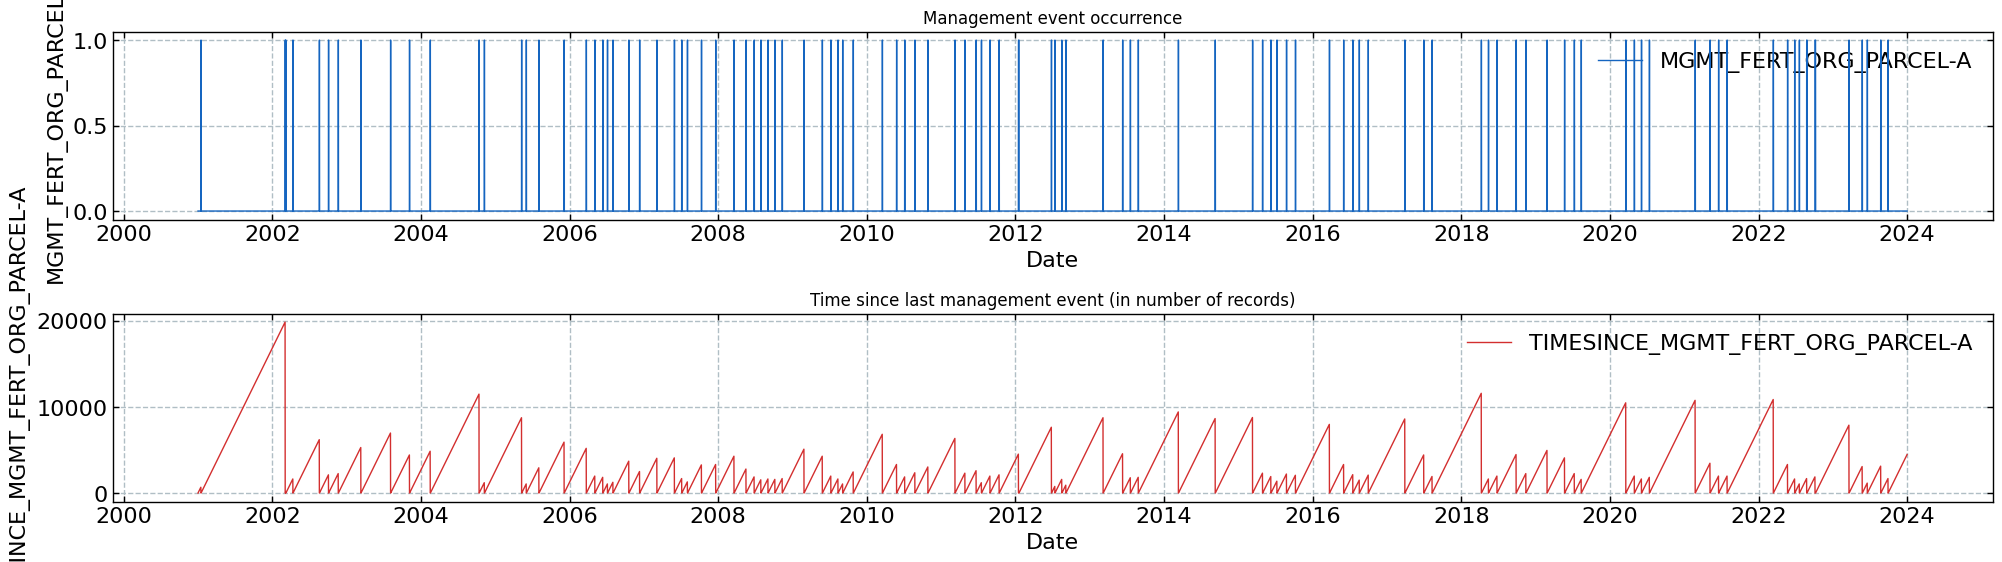

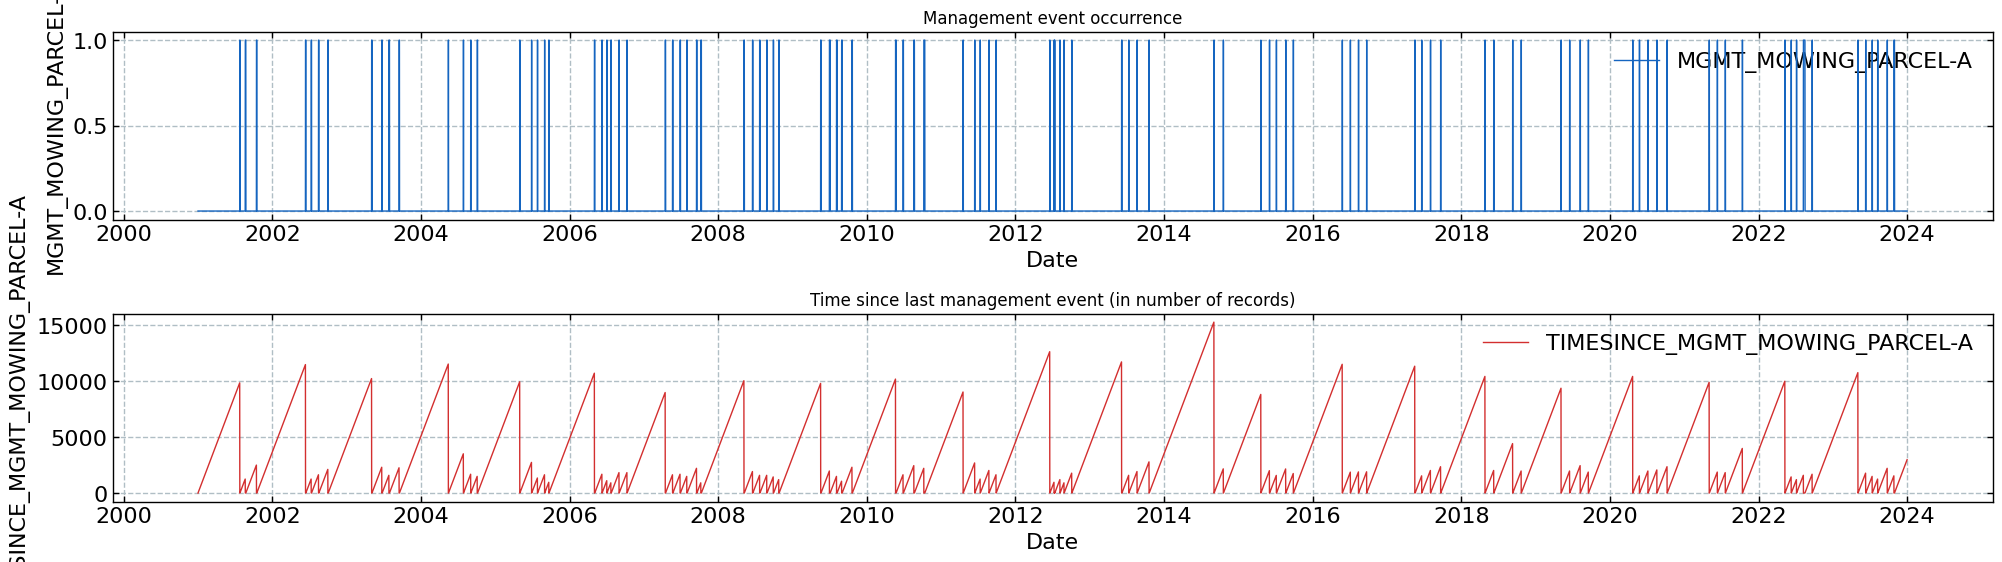

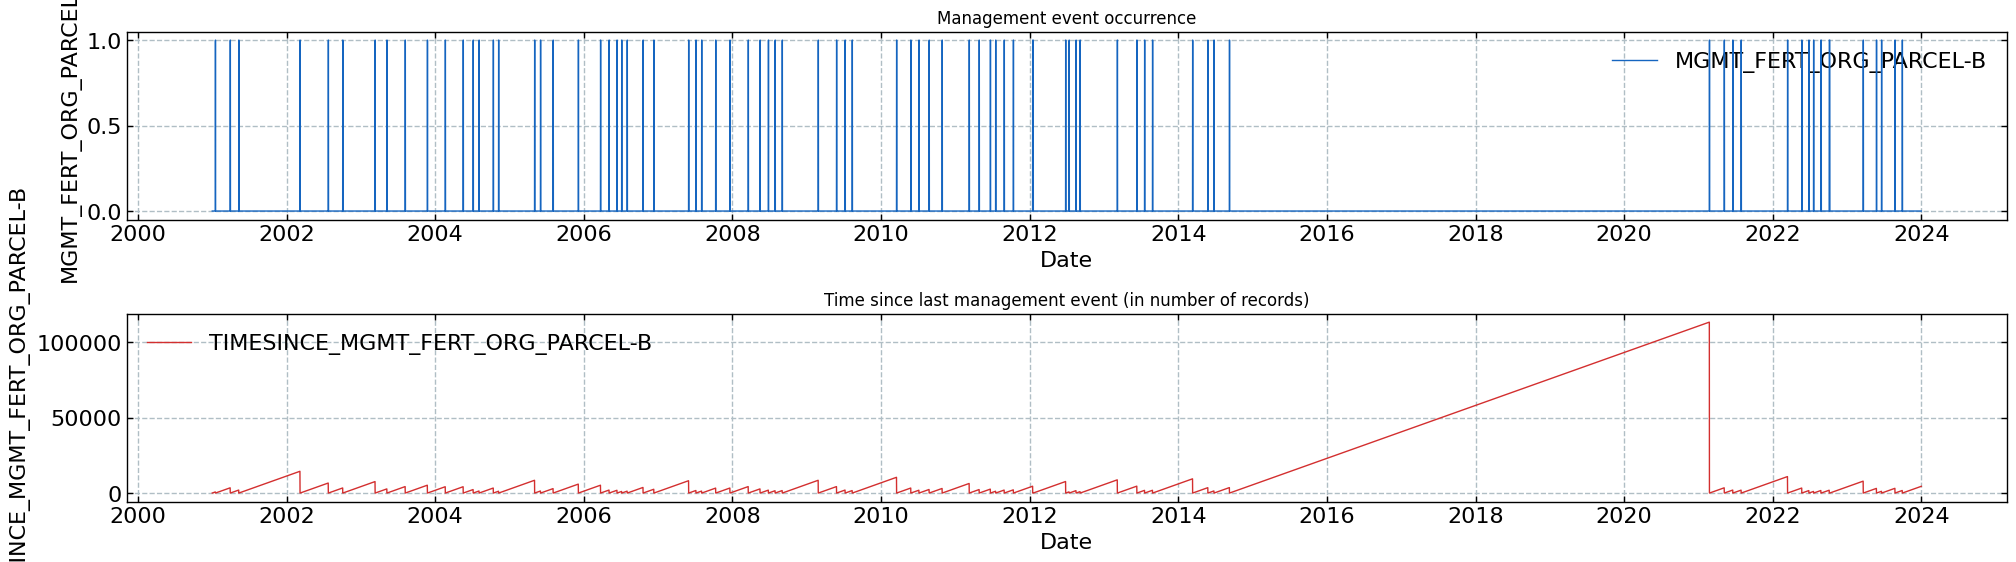

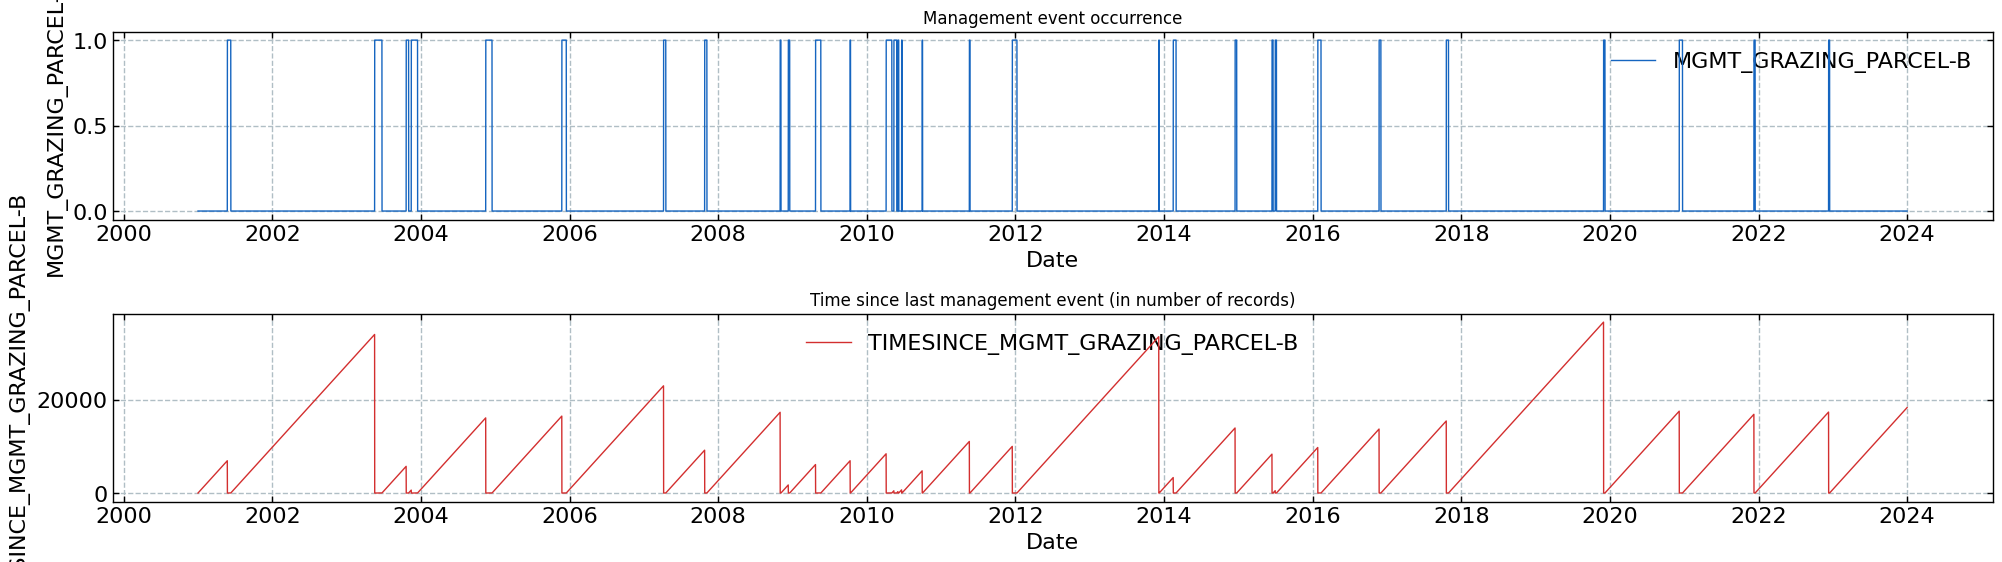

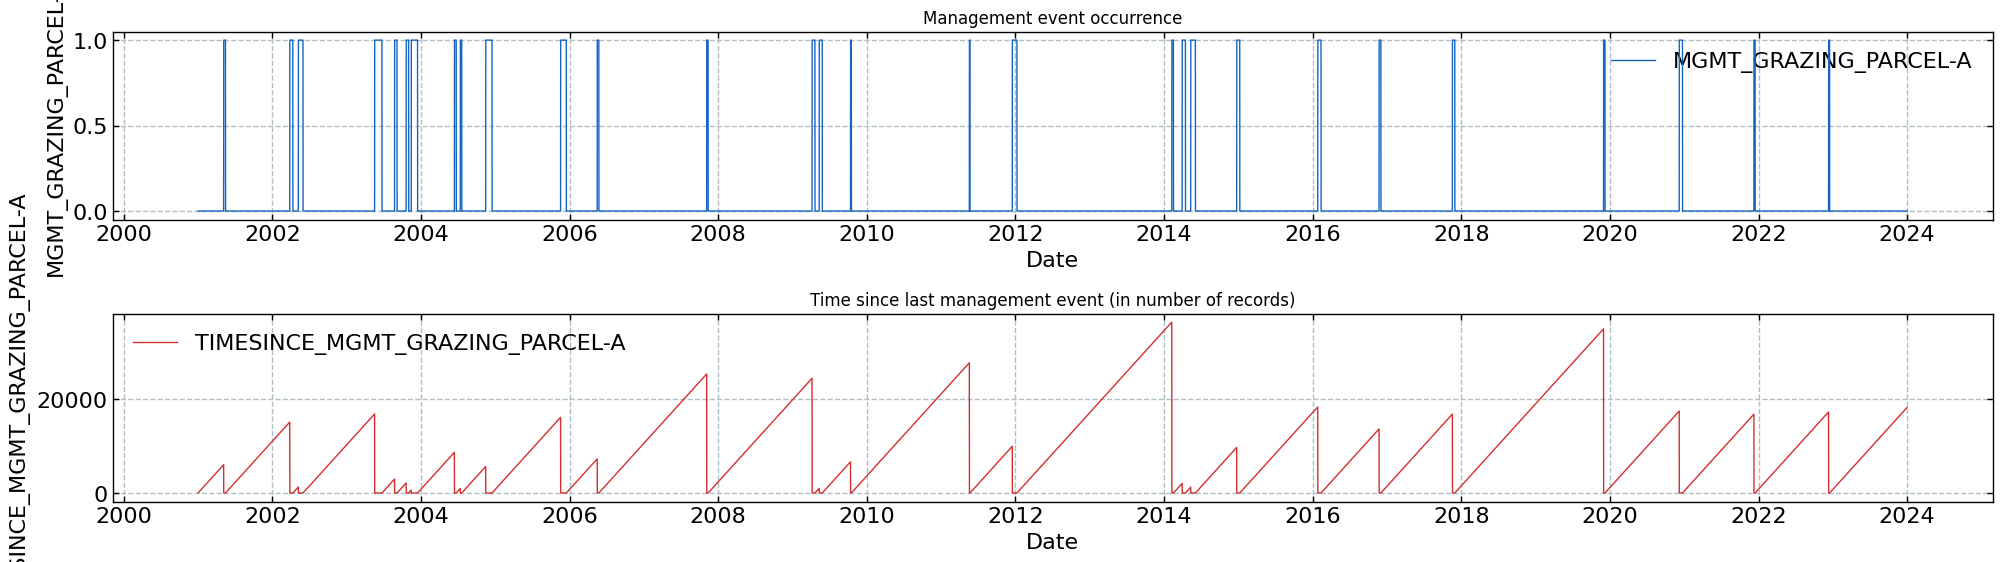

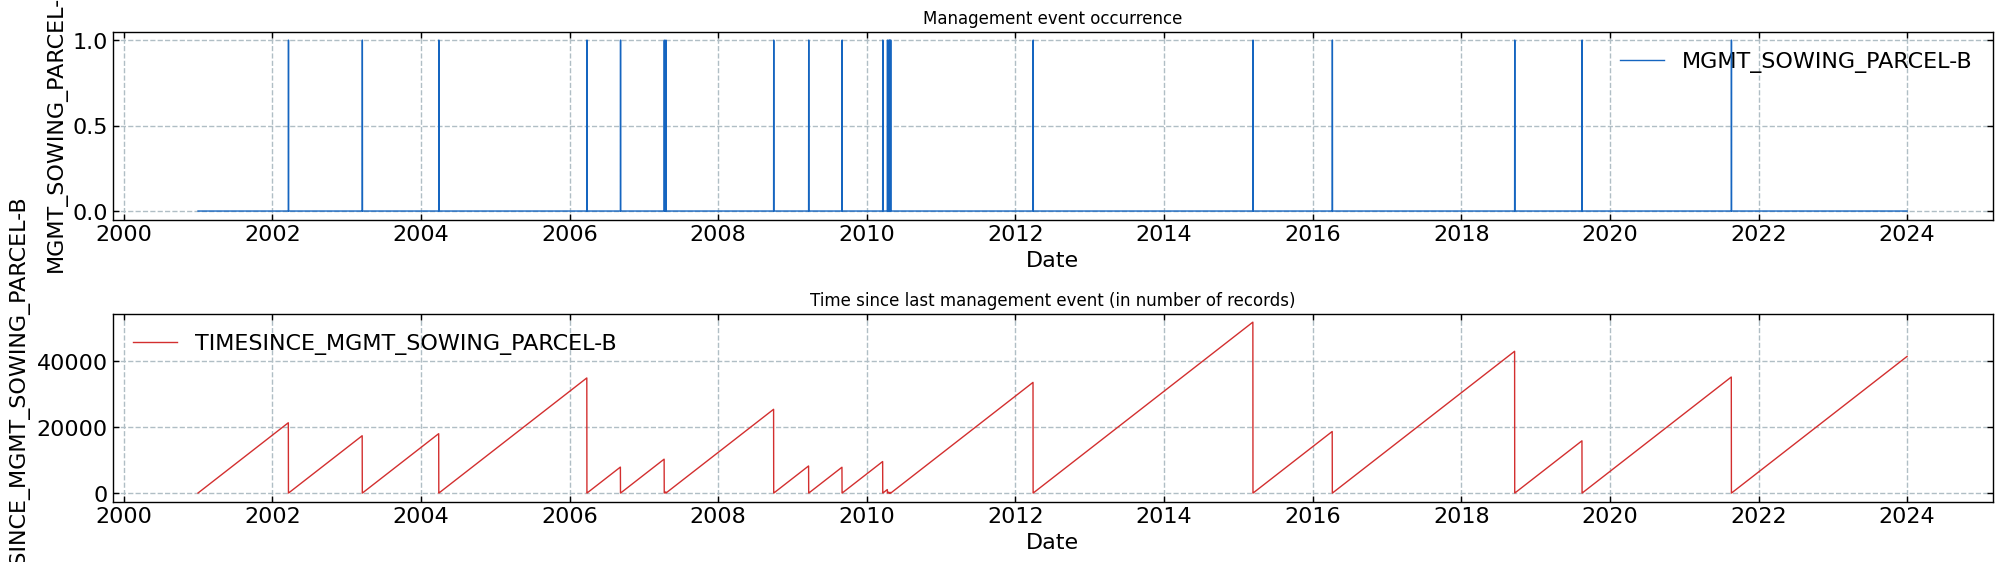

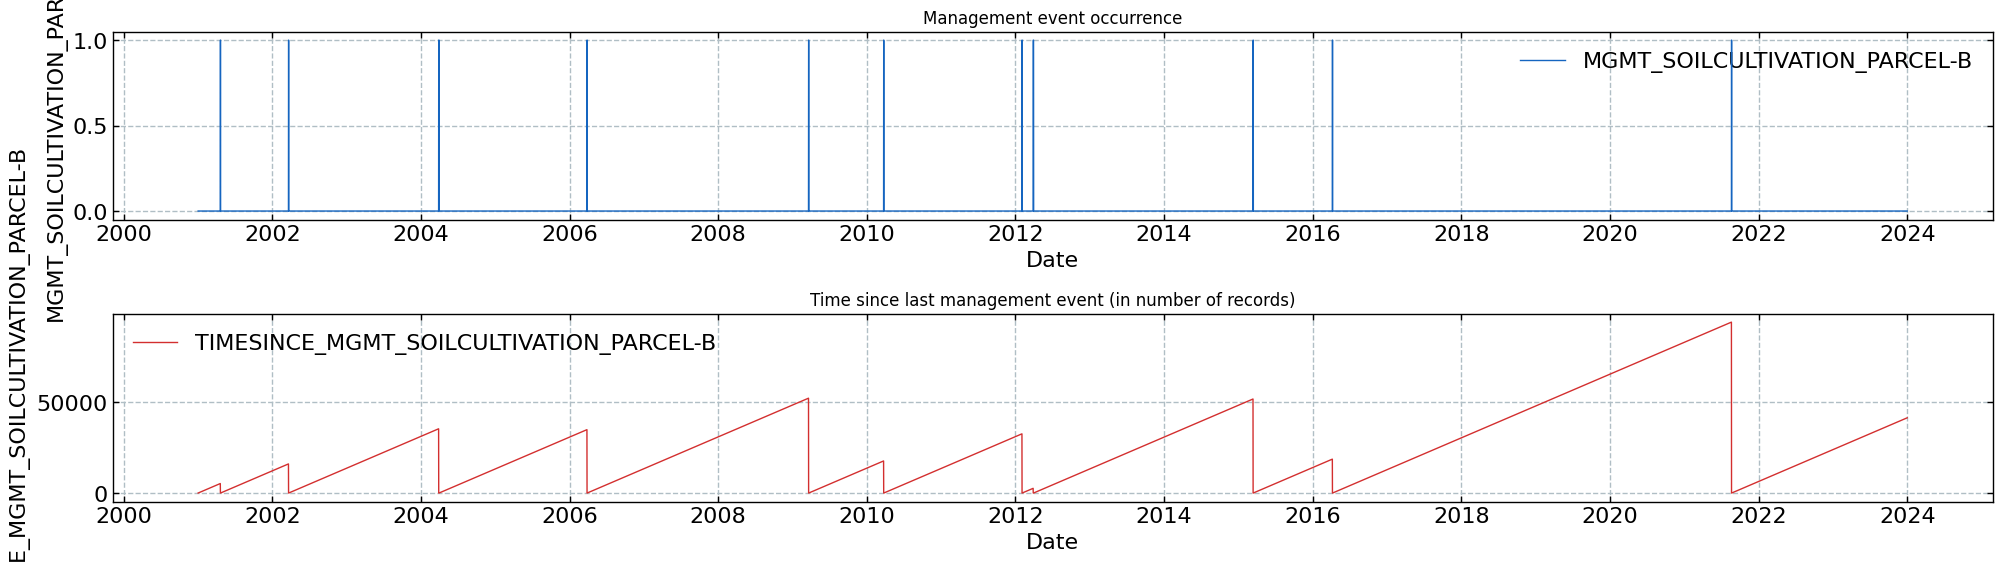

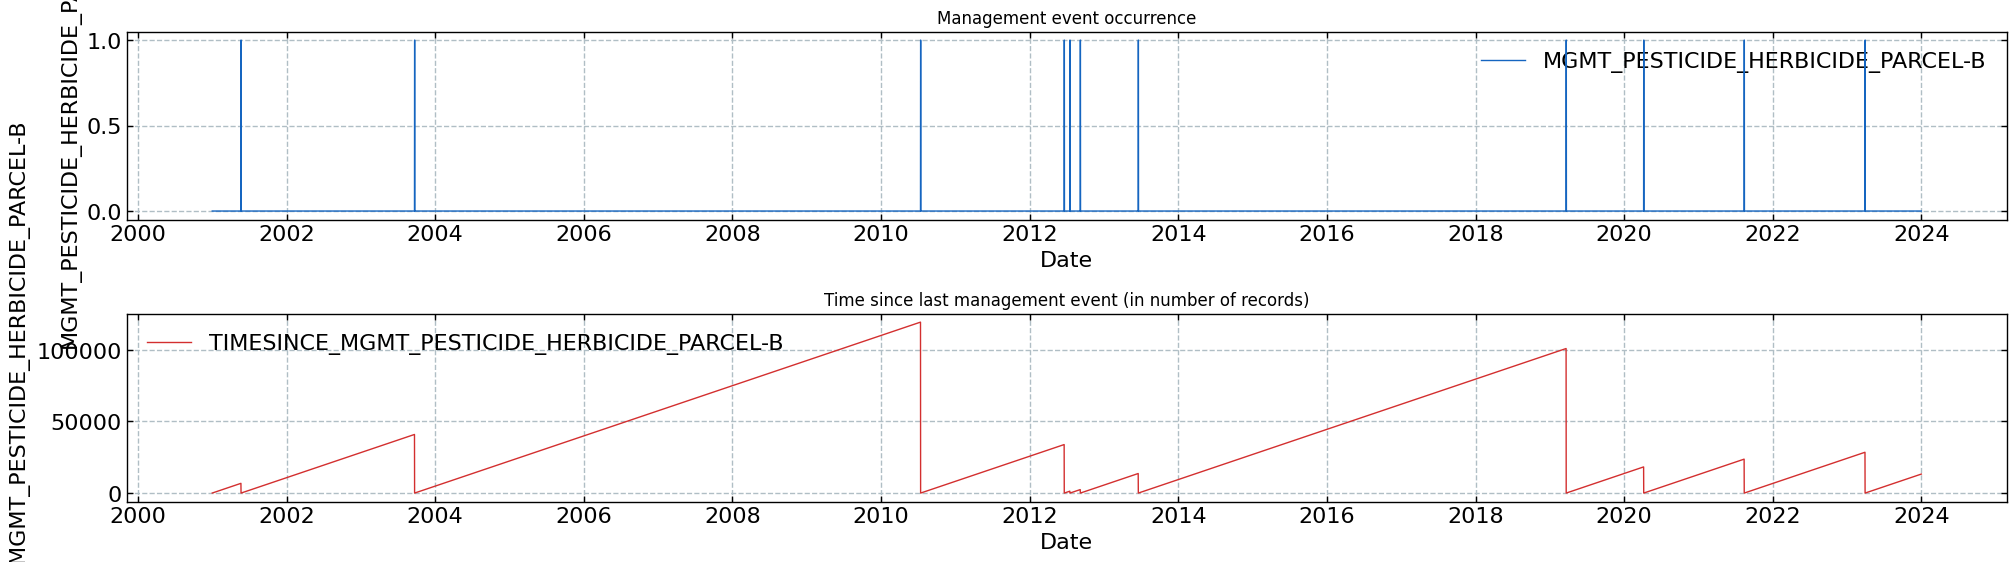

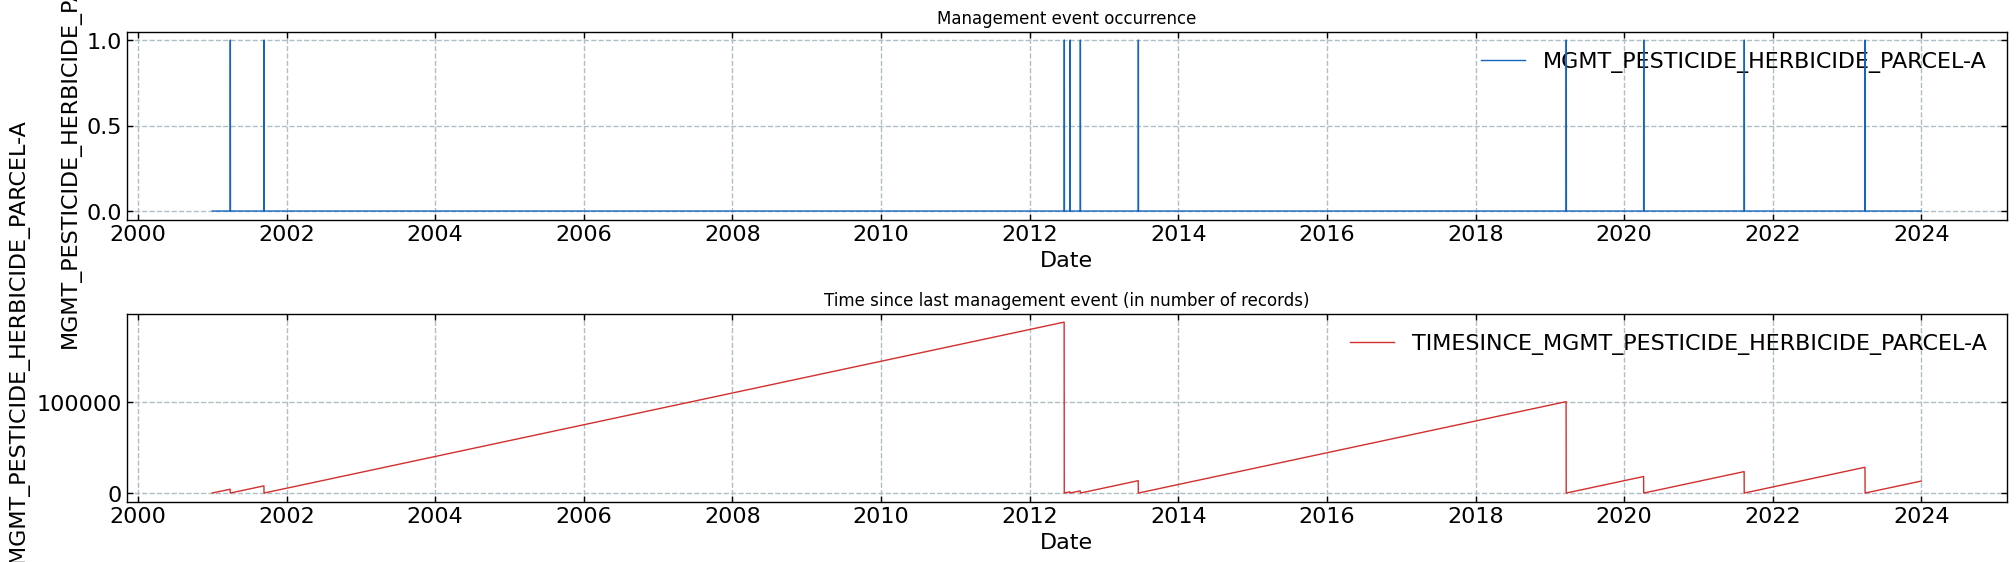

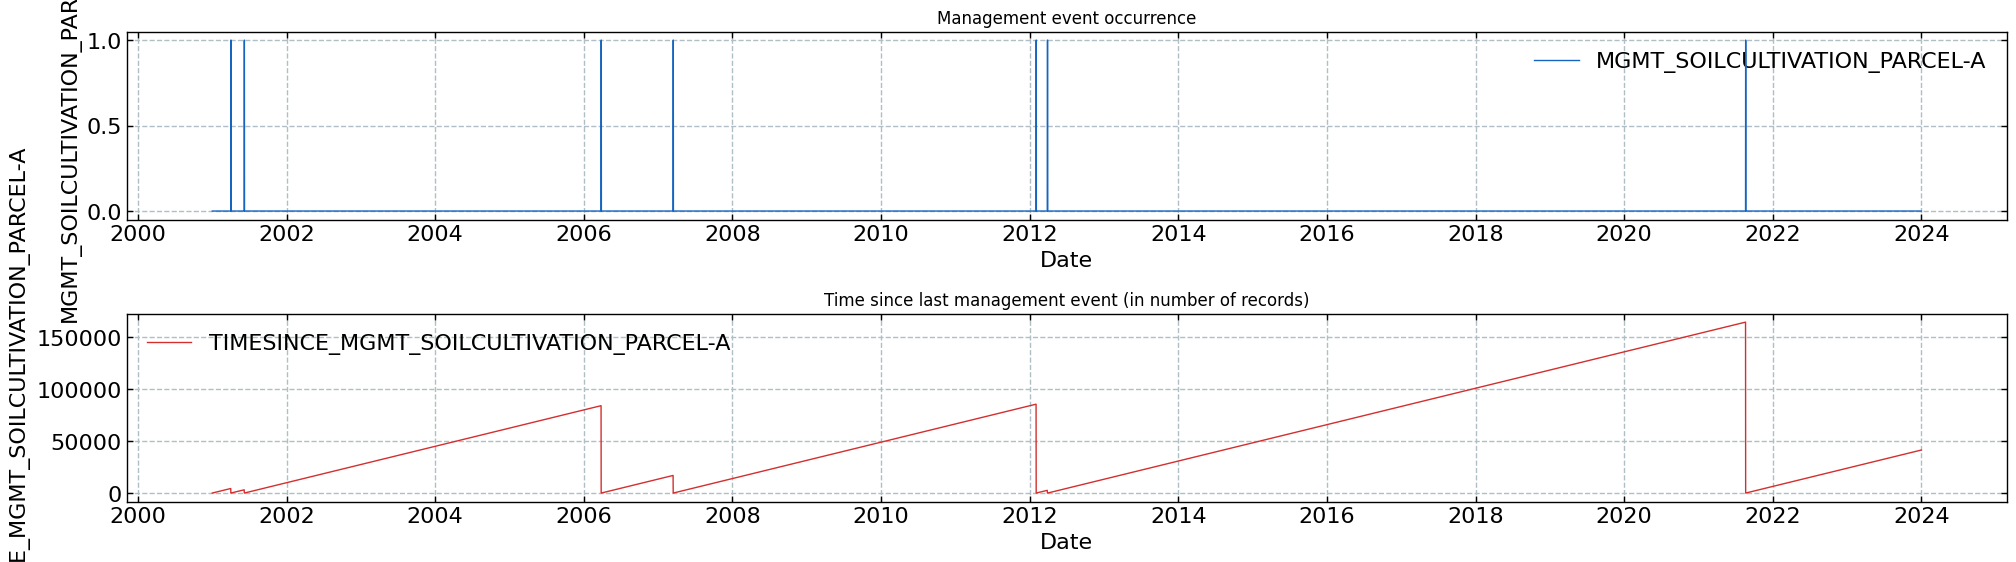

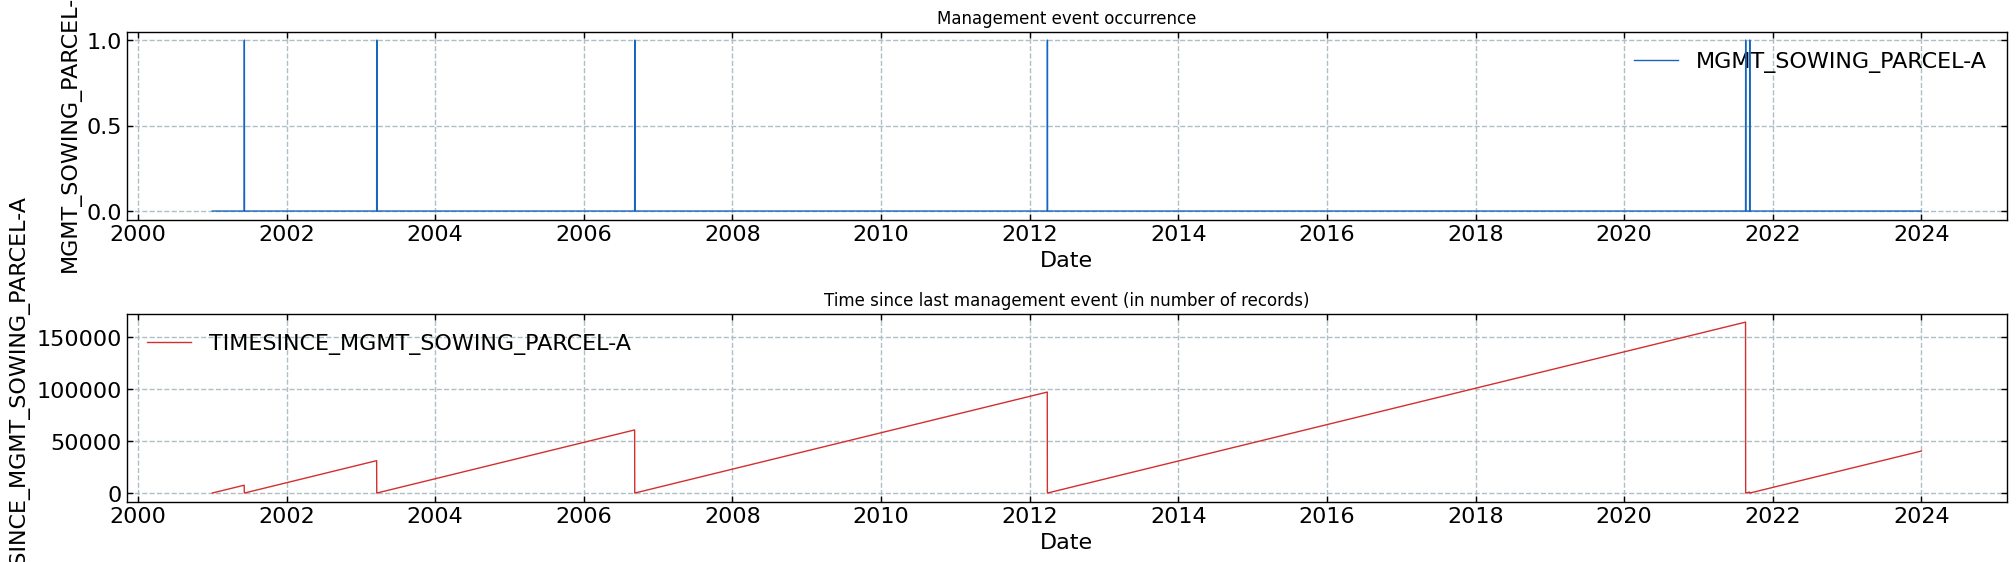

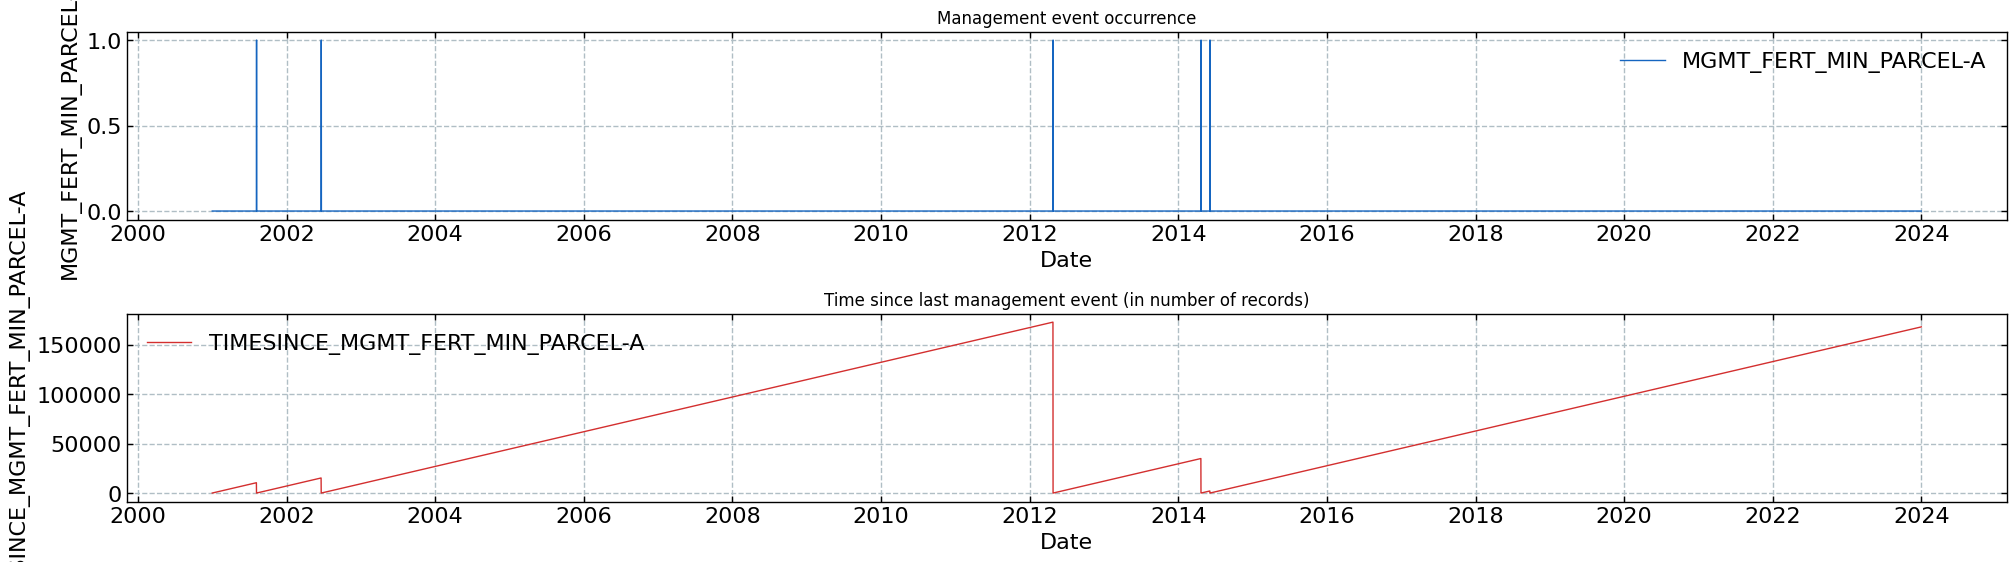

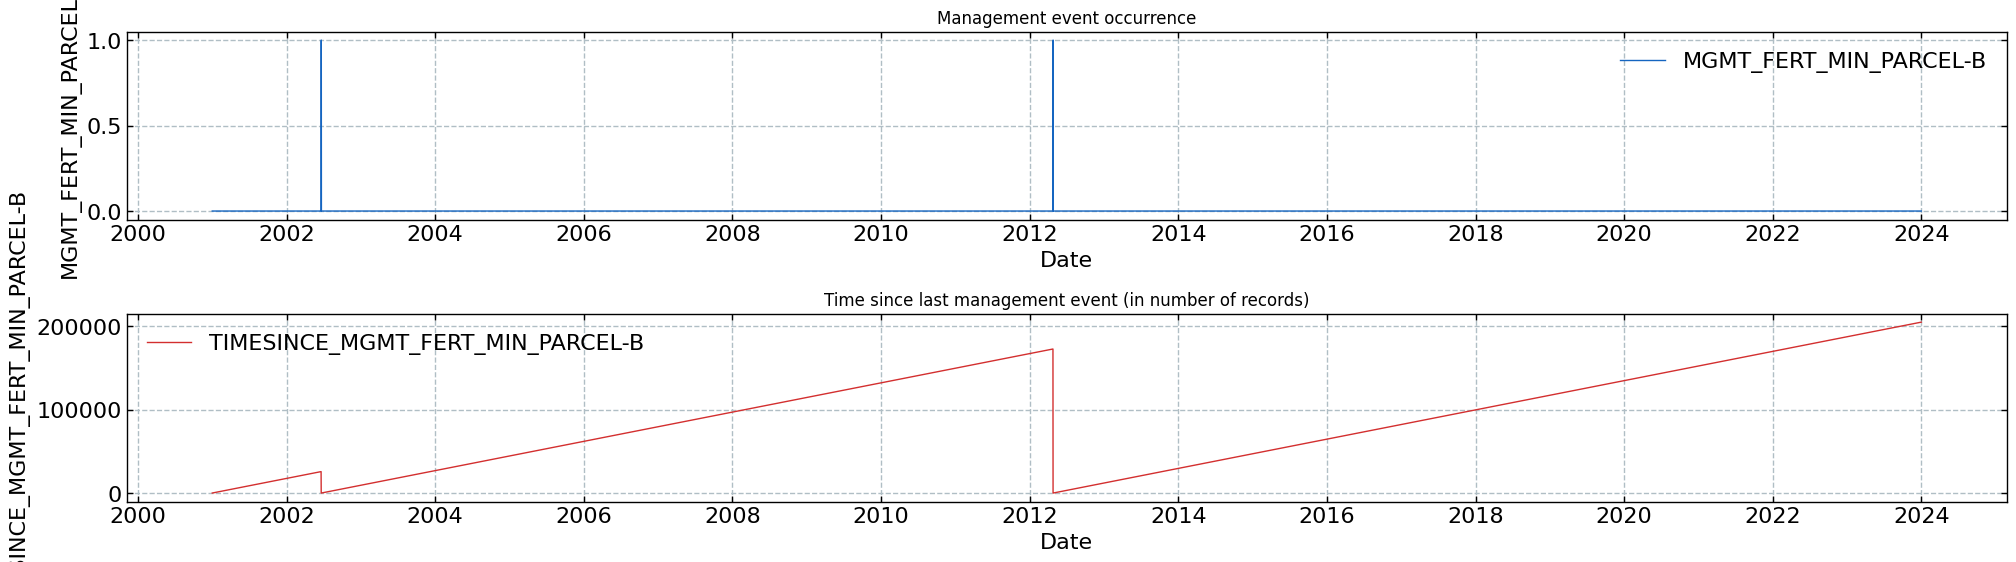

In [21]:
for v in mgmt.columns:
    fig = plt.figure(facecolor='white', figsize=(20, 5), dpi=100, layout='constrained')
    gs = gridspec.GridSpec(2, 1)  # rows, cols
    gs.update(wspace=0.3, hspace=.5, left=0.03, right=0.97, top=0.97, bottom=0.03)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    TimeSeries(ax=ax1, series=mgmt[v]).plot(color='#1565C0')
    TimeSeries(ax=ax2, series=timesincedf[f'TIMESINCE_{v}']).plot(color='#D32F2F')
    ax1.set_title("Management event occurrence", color='black')
    ax2.set_title("Time since last management event (in number of records)", color='black')    

## + Add `TIMESINCE` variables to management data

In [22]:
mgmt = pd.concat([mgmt, timesincedf], axis=1)
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,TIMESINCE_MGMT_FERT_ORG_PARCEL-A,TIMESINCE_MGMT_MOWING_PARCEL-A,TIMESINCE_MGMT_FERT_ORG_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-B,TIMESINCE_MGMT_GRAZING_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3,3,3,3
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4,4,4,4
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2972,4460,2972,4460,18284,18284,41420,41420,13244,13244,41420,40460,167804,204812
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2973,4461,2973,4461,18285,18285,41421,41421,13245,13245,41421,40461,167805,204813
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2974,4462,2974,4462,18286,18286,41422,41422,13246,13246,41422,40462,167806,204814
2023-12-31 23:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2975,4463,2975,4463,18287,18287,41423,41423,13247,13247,41423,40463,167807,204815


In [23]:
collist = mgmt.columns.tolist()
collist

['MGMT_MOWING_PARCEL-B',
 'MGMT_FERT_ORG_PARCEL-A',
 'MGMT_MOWING_PARCEL-A',
 'MGMT_FERT_ORG_PARCEL-B',
 'MGMT_GRAZING_PARCEL-B',
 'MGMT_GRAZING_PARCEL-A',
 'MGMT_SOWING_PARCEL-B',
 'MGMT_SOILCULTIVATION_PARCEL-B',
 'MGMT_PESTICIDE_HERBICIDE_PARCEL-B',
 'MGMT_PESTICIDE_HERBICIDE_PARCEL-A',
 'MGMT_SOILCULTIVATION_PARCEL-A',
 'MGMT_SOWING_PARCEL-A',
 'MGMT_FERT_MIN_PARCEL-A',
 'MGMT_FERT_MIN_PARCEL-B',
 'TIMESINCE_MGMT_MOWING_PARCEL-B',
 'TIMESINCE_MGMT_FERT_ORG_PARCEL-A',
 'TIMESINCE_MGMT_MOWING_PARCEL-A',
 'TIMESINCE_MGMT_FERT_ORG_PARCEL-B',
 'TIMESINCE_MGMT_GRAZING_PARCEL-B',
 'TIMESINCE_MGMT_GRAZING_PARCEL-A',
 'TIMESINCE_MGMT_SOWING_PARCEL-B',
 'TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B',
 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B',
 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A',
 'TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A',
 'TIMESINCE_MGMT_SOWING_PARCEL-A',
 'TIMESINCE_MGMT_FERT_MIN_PARCEL-A',
 'TIMESINCE_MGMT_FERT_MIN_PARCEL-B']

## Initiate footprint management columns

In [24]:
mgmt_cols = [sub.replace('_PARCEL-A', '') for sub in collist]
mgmt_cols = [sub.replace('_PARCEL-B', '') for sub in mgmt_cols]
mgmt_cols = [sub.replace('TIMESINCE_', '') for sub in mgmt_cols]
# mgmt_cols = fp_mgmt_cols.copy()
mgmt_cols = list(set(mgmt_cols))
# display(mgmt_cols)
display(mgmt_cols)

['MGMT_SOILCULTIVATION',
 'MGMT_FERT_ORG',
 'MGMT_FERT_MIN',
 'MGMT_SOWING',
 'MGMT_PESTICIDE_HERBICIDE',
 'MGMT_MOWING',
 'MGMT_GRAZING']

In [25]:
fp_mgmt_cols = [f"{c}_FOOTPRINT" for c in mgmt_cols]
fp_mgmt_cols

['MGMT_SOILCULTIVATION_FOOTPRINT',
 'MGMT_FERT_ORG_FOOTPRINT',
 'MGMT_FERT_MIN_FOOTPRINT',
 'MGMT_SOWING_FOOTPRINT',
 'MGMT_PESTICIDE_HERBICIDE_FOOTPRINT',
 'MGMT_MOWING_FOOTPRINT',
 'MGMT_GRAZING_FOOTPRINT']

In [26]:
mgmt = mgmt.reindex(columns = mgmt.columns.tolist() + fp_mgmt_cols)
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,TIMESINCE_MGMT_SOWING_PARCEL-B,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_FERT_MIN_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_GRAZING_FOOTPRINT
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,2,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,3,3,3,3,3,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,...,4,4,4,4,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,5,5,5,5,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2972,...,41420,41420,13244,13244,41420,40460,167804,204812,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2973,...,41421,41421,13245,13245,41421,40461,167805,204813,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2974,...,41422,41422,13246,13246,41422,40462,167806,204814,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-31 23:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2975,...,41423,41423,13247,13247,41423,40463,167807,204815,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## + Add wind direction to management data

In [27]:
mgmt['WD'] = winddir.copy()
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A,TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A,TIMESINCE_MGMT_SOWING_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-A,TIMESINCE_MGMT_FERT_MIN_PARCEL-B,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_FERT_MIN_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,WD
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,3,3,3,3,3,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,...,4,4,4,4,4,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,5,5,5,5,5,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2972,...,41420,13244,13244,41420,40460,167804,204812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.724
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2973,...,41421,13245,13245,41421,40461,167805,204813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.197
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2974,...,41422,13246,13246,41422,40462,167806,204814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,142.519
2023-12-31 23:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2975,...,41423,13247,13247,41423,40463,167807,204815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.207


## Fill footprint management columns depending on wind direction

- Parcel division runs from 250° to 70°
- Parcel A: >= 250, < 70
- Parcel B: >= 70, < 250

In [28]:
winddir = mgmt['WD'].copy()

locs_parcel_a = (mgmt['WD'] >= 250) | (mgmt['WD'] < 70)
locs_parcel_b = (mgmt['WD'] >= 70) & (mgmt['WD'] < 250)

for m in mgmt_cols:    
    fp_var = f"{m}_FOOTPRINT"
    fp_timesince_var = f"TIMESINCE_{m}_FOOTPRINT"
    
    parcela_var = f"{m}_PARCEL-A"
    parcela_timesince_var = f"TIMESINCE_{m}_PARCEL-A"
    mgmt.loc[locs_parcel_a, fp_var] = mgmt.loc[locs_parcel_a, parcela_var]
    mgmt.loc[locs_parcel_a, fp_timesince_var] = mgmt.loc[locs_parcel_a, parcela_timesince_var]
    
    parcelb_var = f"{m}_PARCEL-B"
    parcelb_timesince_var = f"TIMESINCE_{m}_PARCEL-B"
    mgmt.loc[locs_parcel_b, fp_var] = mgmt.loc[locs_parcel_b, parcelb_var]
    mgmt.loc[locs_parcel_b, fp_timesince_var] = mgmt.loc[locs_parcel_b, parcelb_timesince_var]

In [29]:
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,MGMT_SOILCULTIVATION_FOOTPRINT,MGMT_FERT_ORG_FOOTPRINT,MGMT_FERT_MIN_FOOTPRINT,MGMT_SOWING_FOOTPRINT,MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,MGMT_MOWING_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,WD,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_GRAZING_FOOTPRINT
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2972,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.724,41420.0,4460.0,204812.0,41420.0,13244.0,2972.0,18284.0
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.197,41421.0,4461.0,204813.0,41421.0,13245.0,2973.0,18285.0
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2974,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.519,41422.0,4462.0,204814.0,41422.0,13246.0,2974.0,18286.0
2023-12-31 23:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.207,41423.0,4463.0,204815.0,41423.0,13247.0,2975.0,18287.0


### Plot (example one day)

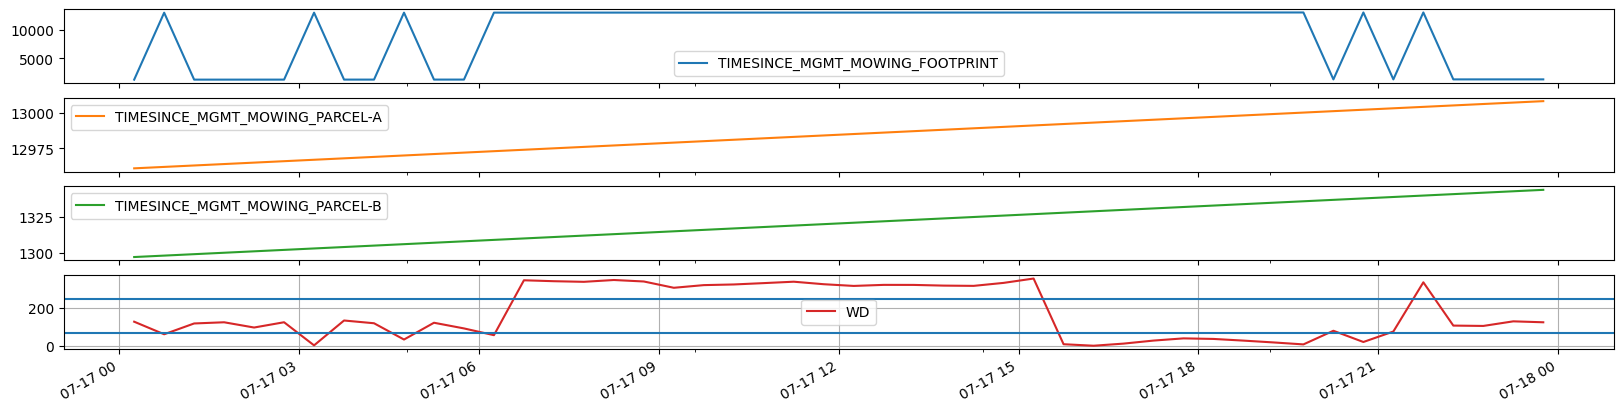

In [30]:
locs = (mgmt.index.year == 2014) & (mgmt.index.month == 7) & (mgmt.index.day == 17)
mgmt.loc[locs, ['TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_PARCEL-A', 'TIMESINCE_MGMT_MOWING_PARCEL-B', 'WD']].plot(x_compat=True, subplots=True, figsize=(20, 5))
plt.axhline(250)
plt.axhline(70)
plt.grid();

</br>

</br>

---

# **FERTILIZER AMOUNT NITROGEN**

---

## Get fertilizer amounts with start and end date

In [31]:
fert_n_col = 'Total Fertilizer N (kg/ha)'
fert_df = mgmt_detailed[['Start', 'End', fert_n_col, 'Parcel']].copy()
fert_df

,Start,End,Total Fertilizer N (kg/ha),Parcel
0,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313,PARCEL-A
1,2001-03-30 00:00:01,2001-03-31 00:00:01,0.000000,PARCEL-A
2,2001-04-02 00:00:01,2001-04-03 00:00:01,0.000000,PARCEL-A
3,2001-05-07 00:00:01,2001-05-16 00:00:01,0.000000,PARCEL-A
4,2001-06-07 00:00:01,2001-06-08 00:00:01,0.000000,PARCEL-A
...,...,...,...,...
573,2024-06-27 00:00:01,2024-06-28 00:00:01,0.000000,PARCEL-B
574,2024-07-17 00:00:01,2024-07-18 00:00:01,0.000000,PARCEL-B
575,2024-08-07 00:00:01,2024-08-08 00:00:01,0.000000,PARCEL-B
576,2024-08-22 00:00:01,2024-08-23 00:00:01,0.000000,PARCEL-B


In [32]:
fert_df['FERT_NAME'] = 'MGMT_FERT_N_TOT_' + fert_df['Parcel']
fert_df

,Start,End,Total Fertilizer N (kg/ha),Parcel,FERT_NAME
0,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
1,2001-03-30 00:00:01,2001-03-31 00:00:01,0.000000,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
2,2001-04-02 00:00:01,2001-04-03 00:00:01,0.000000,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
3,2001-05-07 00:00:01,2001-05-16 00:00:01,0.000000,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
4,2001-06-07 00:00:01,2001-06-08 00:00:01,0.000000,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
...,...,...,...,...,...
573,2024-06-27 00:00:01,2024-06-28 00:00:01,0.000000,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
574,2024-07-17 00:00:01,2024-07-18 00:00:01,0.000000,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
575,2024-08-07 00:00:01,2024-08-08 00:00:01,0.000000,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
576,2024-08-22 00:00:01,2024-08-23 00:00:01,0.000000,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B


In [33]:
locs = fert_df[fert_n_col] > 0
fert_df = fert_df[locs].copy()
fert_df

,Start,End,Total Fertilizer N (kg/ha),Parcel,FERT_NAME
0,2001-01-15 00:00:01,2001-01-16 00:00:01,206.700313,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
8,2001-08-06 00:00:01,2001-08-07 00:00:01,17.550000,PARCEL-A,MGMT_FERT_N_TOT_PARCEL-A
12,2001-01-16 00:00:01,2001-01-17 00:00:01,82.680125,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
13,2001-03-30 00:00:01,2001-03-31 00:00:01,69.358410,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
16,2001-05-11 00:00:01,2001-05-12 00:00:01,81.735500,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
...,...,...,...,...,...
540,2023-03-21 00:00:01,2023-03-22 00:00:01,60.192342,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
543,2023-05-25 00:00:01,2023-05-26 00:00:01,63.651840,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
545,2023-06-19 00:00:01,2023-06-20 00:00:01,53.205900,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B
548,2023-08-24 00:00:01,2023-08-25 00:00:01,59.306856,PARCEL-B,MGMT_FERT_N_TOT_PARCEL-B


## Create empty fertilizer dataframe with full timestamp

In [34]:
fert_n = pd.DataFrame(index=timestamp_full, columns=['MGMT_FERT_N_TOT', 'MGMT_FERT_N_TOT_PARCEL-A', 'MGMT_FERT_N_TOT_PARCEL-B'])
fert_n

,MGMT_FERT_N_TOT,MGMT_FERT_N_TOT_PARCEL-A,MGMT_FERT_N_TOT_PARCEL-B
2001-01-01 00:15:00,NaN,NaN,NaN
2001-01-01 00:45:00,NaN,NaN,NaN
2001-01-01 01:15:00,NaN,NaN,NaN
2001-01-01 01:45:00,NaN,NaN,NaN
2001-01-01 02:15:00,NaN,NaN,NaN
...,...,...,...
2023-12-31 21:45:00,NaN,NaN,NaN
2023-12-31 22:15:00,NaN,NaN,NaN
2023-12-31 22:45:00,NaN,NaN,NaN
2023-12-31 23:15:00,NaN,NaN,NaN


## Insert fertilizer amount into dataframe with full timestamp

In [35]:
for ix, event in fert_df.iterrows():
    n_amount = event[fert_n_col]
    fert_name = event['FERT_NAME']
    start = event['Start']
    end = event['End']
    # print(fert_name, n_amount, start, end)    
    locs = (fert_n.index >= start) & (fert_n.index <= end)        
    fert_n.loc[locs, fert_name] = n_amount  # Insert in column for this parcel    

In [36]:
fert_n = fert_n.fillna(0)

C:\Users\holukas\AppData\Local\Temp\ipykernel_12260\2305635515.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fert_n = fert_n.fillna(0)


In [37]:
fert_n['MGMT_FERT_N_TOT'] = fert_n['MGMT_FERT_N_TOT_PARCEL-A'].add(fert_n['MGMT_FERT_N_TOT_PARCEL-B'])

In [38]:
fert_n

,MGMT_FERT_N_TOT,MGMT_FERT_N_TOT_PARCEL-A,MGMT_FERT_N_TOT_PARCEL-B
2001-01-01 00:15:00,0.0,0.0,0.0
2001-01-01 00:45:00,0.0,0.0,0.0
2001-01-01 01:15:00,0.0,0.0,0.0
2001-01-01 01:45:00,0.0,0.0,0.0
2001-01-01 02:15:00,0.0,0.0,0.0
...,...,...,...
2023-12-31 21:45:00,0.0,0.0,0.0
2023-12-31 22:15:00,0.0,0.0,0.0
2023-12-31 22:45:00,0.0,0.0,0.0
2023-12-31 23:15:00,0.0,0.0,0.0


## + Add winddirection for fertilizer data

In [39]:
fert_n['WD'] = winddir.copy()
fert_n

,MGMT_FERT_N_TOT,MGMT_FERT_N_TOT_PARCEL-A,MGMT_FERT_N_TOT_PARCEL-B,WD
2001-01-01 00:15:00,0.0,0.0,0.0,NaN
2001-01-01 00:45:00,0.0,0.0,0.0,NaN
2001-01-01 01:15:00,0.0,0.0,0.0,NaN
2001-01-01 01:45:00,0.0,0.0,0.0,NaN
2001-01-01 02:15:00,0.0,0.0,0.0,NaN
...,...,...,...,...
2023-12-31 21:45:00,0.0,0.0,0.0,116.724
2023-12-31 22:15:00,0.0,0.0,0.0,116.197
2023-12-31 22:45:00,0.0,0.0,0.0,142.519
2023-12-31 23:15:00,0.0,0.0,0.0,140.207


## Fill footprint fertilizer column

In [40]:
fert_n['MGMT_FERT_N_TOT_FOOTPRINT'] = 0

In [41]:
locs_parcel_a = (mgmt['WD'] >= 250) | (mgmt['WD'] < 70)
locs_parcel_b = (mgmt['WD'] >= 70) & (mgmt['WD'] < 250)
fert_n.loc[locs_parcel_a, 'MGMT_FERT_N_TOT_FOOTPRINT'] = fert_n.loc[locs_parcel_a, 'MGMT_FERT_N_TOT_PARCEL-A']
fert_n.loc[locs_parcel_b, 'MGMT_FERT_N_TOT_FOOTPRINT'] = fert_n.loc[locs_parcel_b, 'MGMT_FERT_N_TOT_PARCEL-B']
fert_n

C:\Users\holukas\AppData\Local\Temp\ipykernel_12260\1952127981.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  fert_n.loc[locs_parcel_a, 'MGMT_FERT_N_TOT_FOOTPRINT'] = fert_n.loc[locs_parcel_a, 'MGMT_FERT_N_TOT_PARCEL-A']


,MGMT_FERT_N_TOT,MGMT_FERT_N_TOT_PARCEL-A,MGMT_FERT_N_TOT_PARCEL-B,WD,MGMT_FERT_N_TOT_FOOTPRINT
2001-01-01 00:15:00,0.0,0.0,0.0,NaN,0.0
2001-01-01 00:45:00,0.0,0.0,0.0,NaN,0.0
2001-01-01 01:15:00,0.0,0.0,0.0,NaN,0.0
2001-01-01 01:45:00,0.0,0.0,0.0,NaN,0.0
2001-01-01 02:15:00,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...
2023-12-31 21:45:00,0.0,0.0,0.0,116.724,0.0
2023-12-31 22:15:00,0.0,0.0,0.0,116.197,0.0
2023-12-31 22:45:00,0.0,0.0,0.0,142.519,0.0
2023-12-31 23:15:00,0.0,0.0,0.0,140.207,0.0


### Plot

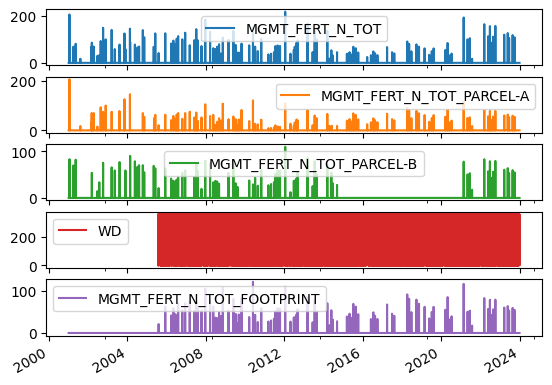

In [42]:
fert_n.plot(x_compat=True, subplots=True);

## + Add fertilizer amounts to management data

In [43]:
mgmt = pd.concat([mgmt, fert_n], axis=1)
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,MGMT_MOWING_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,WD,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_GRAZING_FOOTPRINT,MGMT_FERT_N_TOT,MGMT_FERT_N_TOT_PARCEL-A,MGMT_FERT_N_TOT_PARCEL-B,WD,MGMT_FERT_N_TOT_FOOTPRINT
2001-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2001-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2001-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2001-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2001-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2972,...,0.0,0.0,116.724,41420.0,4460.0,204812.0,41420.0,13244.0,2972.0,18284.0,0.0,0.0,0.0,116.724,0.0
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2973,...,0.0,0.0,116.197,41421.0,4461.0,204813.0,41421.0,13245.0,2973.0,18285.0,0.0,0.0,0.0,116.197,0.0
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2974,...,0.0,0.0,142.519,41422.0,4462.0,204814.0,41422.0,13246.0,2974.0,18286.0,0.0,0.0,0.0,142.519,0.0
2023-12-31 23:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2975,...,0.0,0.0,140.207,41423.0,4463.0,204815.0,41423.0,13247.0,2975.0,18287.0,0.0,0.0,0.0,140.207,0.0


</br>

# Export data to file

## Keep management info from 2005 onwards

In [44]:
keeplocs = mgmt.index.year >= 2005
mgmt = mgmt.loc[keeplocs].copy()
mgmt

,MGMT_MOWING_PARCEL-B,MGMT_FERT_ORG_PARCEL-A,MGMT_MOWING_PARCEL-A,MGMT_FERT_ORG_PARCEL-B,MGMT_GRAZING_PARCEL-B,MGMT_GRAZING_PARCEL-A,MGMT_SOWING_PARCEL-B,MGMT_SOILCULTIVATION_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-B,MGMT_PESTICIDE_HERBICIDE_PARCEL-A,MGMT_SOILCULTIVATION_PARCEL-A,MGMT_SOWING_PARCEL-A,MGMT_FERT_MIN_PARCEL-A,MGMT_FERT_MIN_PARCEL-B,TIMESINCE_MGMT_MOWING_PARCEL-B,...,MGMT_MOWING_FOOTPRINT,MGMT_GRAZING_FOOTPRINT,WD,TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT,TIMESINCE_MGMT_FERT_ORG_FOOTPRINT,TIMESINCE_MGMT_FERT_MIN_FOOTPRINT,TIMESINCE_MGMT_SOWING_FOOTPRINT,TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT,TIMESINCE_MGMT_MOWING_FOOTPRINT,TIMESINCE_MGMT_GRAZING_FOOTPRINT,MGMT_FERT_N_TOT,MGMT_FERT_N_TOT_PARCEL-A,MGMT_FERT_N_TOT_PARCEL-B,WD,MGMT_FERT_N_TOT_FOOTPRINT
2005-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4177,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2005-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4178,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2005-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2005-01-01 01:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
2005-01-01 02:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 21:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2972,...,0.0,0.0,116.724,41420.0,4460.0,204812.0,41420.0,13244.0,2972.0,18284.0,0.0,0.0,0.0,116.724,0.0
2023-12-31 22:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2973,...,0.0,0.0,116.197,41421.0,4461.0,204813.0,41421.0,13245.0,2973.0,18285.0,0.0,0.0,0.0,116.197,0.0
2023-12-31 22:45:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2974,...,0.0,0.0,142.519,41422.0,4462.0,204814.0,41422.0,13246.0,2974.0,18286.0,0.0,0.0,0.0,142.519,0.0
2023-12-31 23:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2975,...,0.0,0.0,140.207,41423.0,4463.0,204815.0,41423.0,13247.0,2975.0,18287.0,0.0,0.0,0.0,140.207,0.0


## Plot

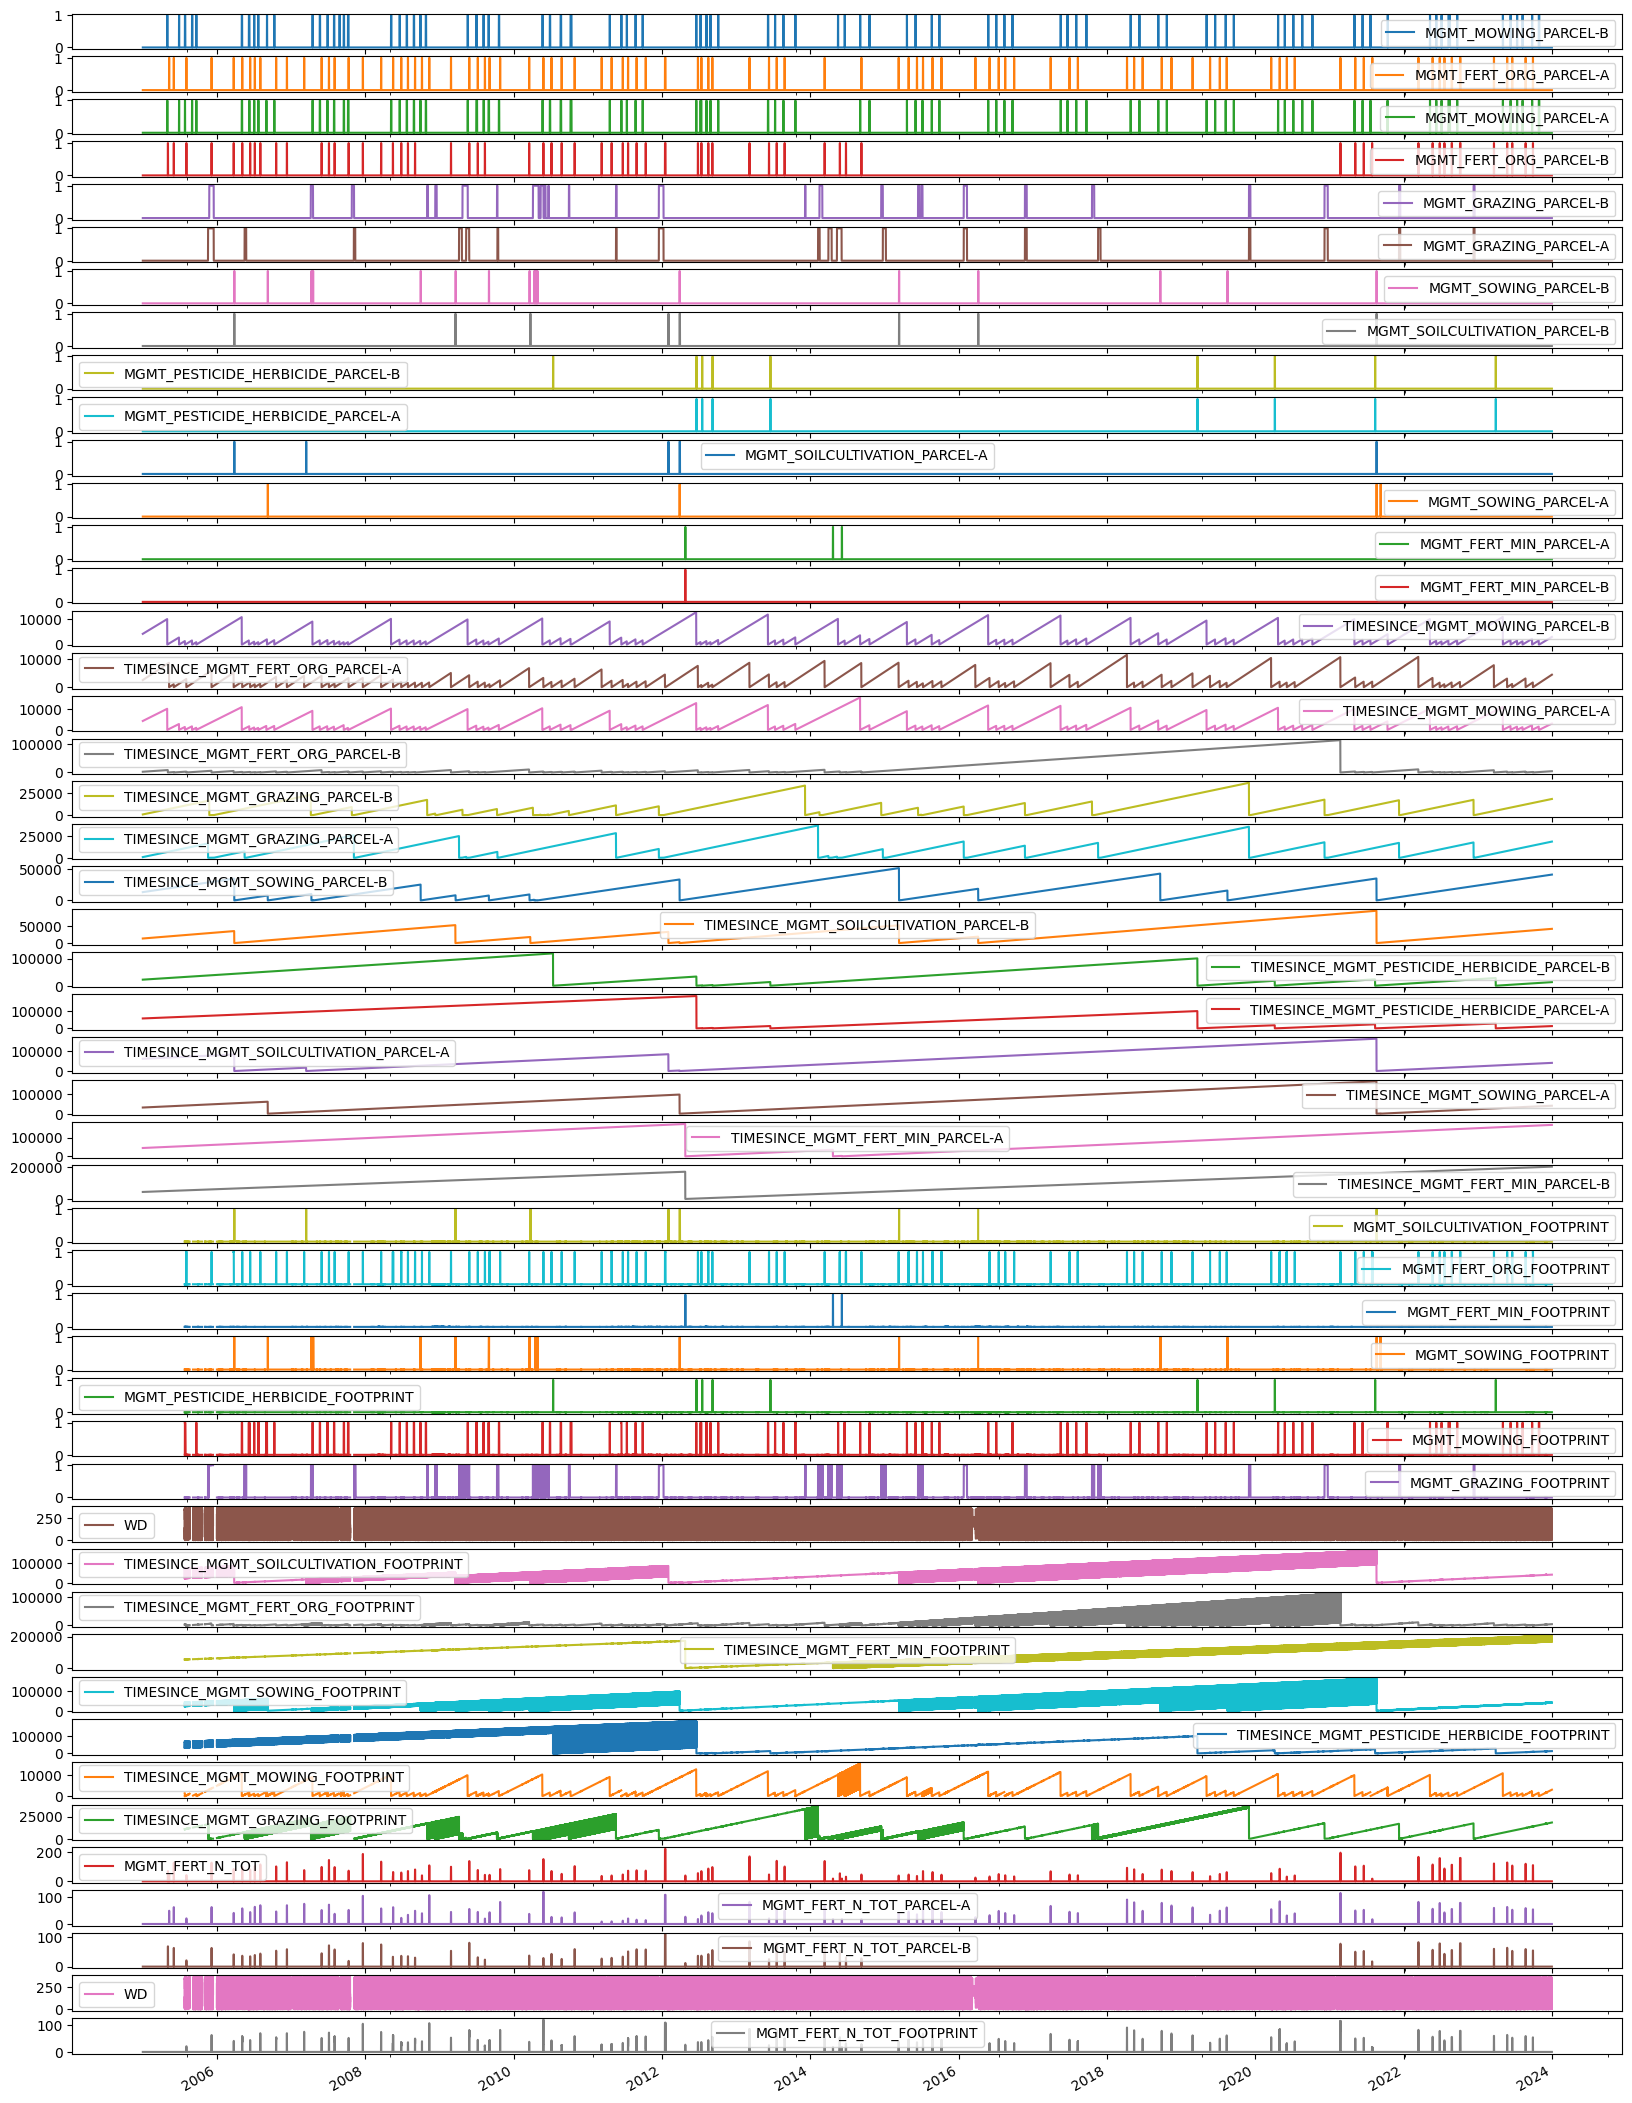

In [49]:
mgmt.plot(x_compat=True, subplots=True, figsize=(20, 30));

## Save to file

In [48]:
mgmt.to_csv("16.3_mgmt_full_timestamp.csv")

In [46]:
# # nitrogen fert is simply a column with the amount of nitrogen per hectar which was applied
# # it consists of zeros and then the amount applied on the day of the fertilization

# df['n_fert_decay'] = df['nitrogen_fert']
# df['n_fert_decay'].replace(0, pd.NA, inplace=True) # Replace 0 with NaN

# # Function to fill NaNs with an exponential decline from the last known value + previous decay residuals
# def fill_exponential_decline(series, decay_factor=0.9985):
#     last_value = None
#     residual = 0
#     for i in range(len(series)):
#         if pd.isna(series.iloc[i]):
#             if last_value is not None:
#                 residual *= decay_factor
#                 series.iloc[i] = residual
#             else:
#                 series.iloc[i] = pd.NA
#         else:
#             if last_value is not None:
#                 residual = last_value * decay_factor + residual * decay_factor
#             else:
#                 residual = series.iloc[i]
#             last_value = series.iloc[i]
#             series.iloc[i] += residual - series.iloc[i]
#     return series

# # Apply the function to fill NaNs
# df['n_fert_decay'] = fill_exponential_decline(df['n_fert_decay'])